In [1]:
%load_ext autoreload
import sys
from scipy.integrate import quad
sys.path.append("../..")

outfolder = '/Users/gregoryridgway/Desktop/Junk/'

# Notebook Initialization

In [6]:
%autoreload
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc_file('./matplotlibrc')

import pickle
import numpy as np
# np.set_printoptions(threshold=np.nan)
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import interp1d

# import darkhistory.physics as phys
from scipy.integrate import odeint
import compositools as ct

from tqdm import tqdm_notebook as tqdm

In [7]:
#Parameters for most of this notebook
LambdaD = 1e12
Nc = 3
Nf = 1

### Test (1): Do we define $g_*$ correctly?

Text(0.5, 1.0, 'Effective Number of DoF for Entropy')

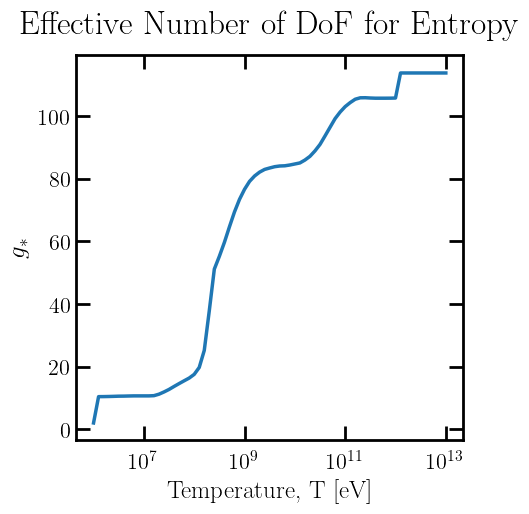

In [8]:
%autoreload
tmp_Ts = 10**np.arange(6,13.1,.1)

plt.figure(figsize=(5,5))
ax = plt.gca()
ax.set_xscale('log')
plt.plot(tmp_Ts, ct.get_gstar(tmp_Ts, DM=True, LambdaD=1e12, Nc=3))
plt.xlabel('Temperature, T [eV] ')
plt.ylabel('$g_*$')
plt.title('Effective Number of DoF for Entropy')

### Test (2): Do we compute $n$ and $Y_{\mathrm{eq}}$ correctly?

set $x = T/m$, and $y = p/m$
$$
n = \frac{g T^3}{2 \pi^2}\int_0^\infty dy \frac{y^2}{e^{\sqrt{y^2+x^2}}\pm1}
$$
When x is small (smaller than $0.1$), we drop x from the above equation, and when it's large (larger than $10$) we drop the $\pm1$ to find

$$
\begin{align}
n & = \alpha g \frac{\zeta(3) T^3}{\pi^2},\text{ for x<0.1} \\
n & = g \left(\frac{m T}{2 \pi}\right)^{\frac{3}{2}} e^{-x},\text{ for x>10}
\end{align}
$$
where $\alpha = 1 (3/4)$ for bosons (fermions). For all other values of x we make a 1D plot along x that we interpolate over.

Text(0.5, 1.0, 'm = 1eV')

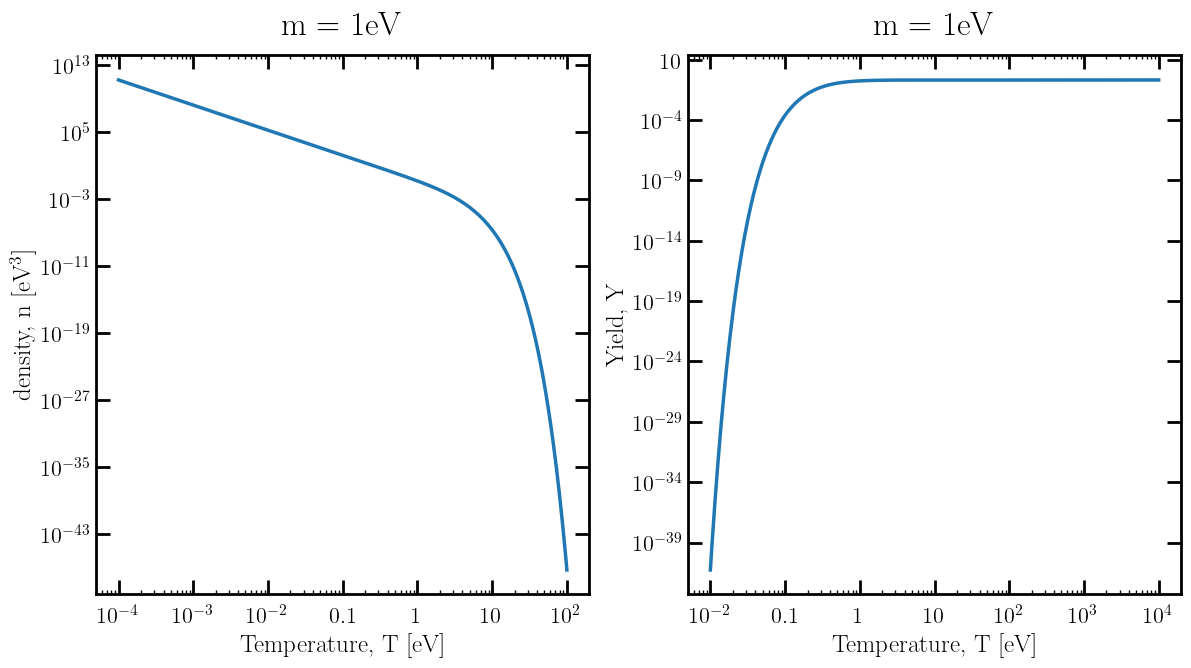

In [9]:
%autoreload
fig, axarr = plt.subplots(1, 2, figsize=(14,7))
tmp_xs = 10**np.arange(np.log10(.0001),np.log10(100)+.01,.01)
axarr[0].loglog()
axarr[0].plot(tmp_xs, ct.n(1/tmp_xs, 1, 2, part='fermion'))
axarr[0].set_xlabel('Temperature, T [eV]')
axarr[0].set_ylabel(r'density, n [eV$^3$]')
axarr[0].set_title(r'm = 1eV')

axarr[1].loglog()
axarr[1].plot(1/tmp_xs, ct.Yeq(2, 1, tmp_xs, LambdaD, Nc, part='fermion'))
axarr[1].set_xlabel('Temperature, T [eV]')
axarr[1].set_ylabel(r'Yield, Y')
axarr[1].set_title(r'm = 1eV')

# Abundance Calculations

We will perform the asymmetric DM relic abundance calculation outlined in [[1]](#cite_ADM), with the help of [[2]](#cite_WIMP_Miracle). We start by defining the yield, $Y^{\pm} = \frac{n^\pm}{s}$, where the entropy $s = (2 \pi^2 / 45) g_* T^3$, and the effective number of degrees of freedom has been WebplotDigitized from Fig. 2.

$$
\frac1{a^3}\frac{d(n_q a^3)}{dt} = -<\sigma v>(n_q^2 - (n_q^{eq})^2)
$$

$$
\frac{dY}{dt} = -\frac{<\sigma v>}{s}(n_q^2 - (n_q^{eq})^2)
$$

but $d\ln x = -d\ln T = -d\ln(1+z) = H dt$

$$
\frac{dY}{d\ln x} = -\frac{s}{H} <\sigma v>(Y_q^2 - (Y_q^{eq})^2)
$$

Then use $H = \frac{\pi T^2}{M_{pl}}\sqrt{\frac{g_*}{90}}$ where $M_{pl} \sim 2.4 \times 10^{18}$ GeV.

### Test (3): WIMP Miracle

Let's first double-check that we can reproduce the WIMP miracle.

[10, 100, 1e-14, 1.0375276072506227e-05]

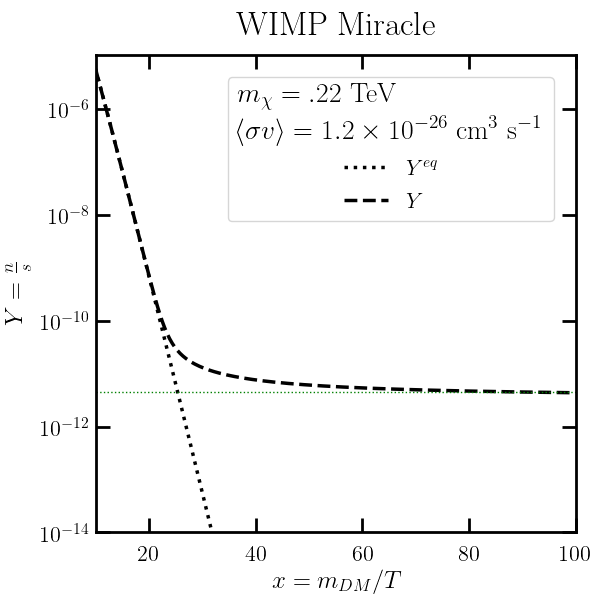

In [10]:
%autoreload
# parameters
mDM     = .22 * LambdaD    # 100 GeV
sigmav  = (.007/mDM)**2#1/mDM**2#5e-9*1e-18 # in eV^-2

# initial conditions
xinit = 10       # initial x
Tinit = mDM / xinit # initial temperature

lnx_vec = np.arange(np.log(xinit), np.log(100), .01)
x_vec = np.exp(lnx_vec)
init_cond = np.array(np.log(ct.Yeq(2, mDM, xinit, LambdaD, Nc)*1.001))

sym = ct.get_history(init_cond, lnx_vec, mDM, sigmav, LambdaD, Nc, gDM=2)

plt.figure()
ax = plt.gca()
ax.set_yscale('log')
xtmp = 10**np.arange(np.log10(xinit), np.log10(40), .01)
plt.plot(xtmp, ct.Yeq(2, mDM, xtmp, LambdaD, Nc), color='k', linestyle=':', label=r'$Y^{eq}$')
plt.plot(x_vec, sym,      color='k',    linestyle='dashed', label=r'$Y$')


plt.xlabel(r'$x = m_{DM}/T$')
plt.ylabel(r'$Y = \frac{n}{s}$')
leg = plt.legend()
leg.set_title('$m_\chi = .22$ TeV \n '
              +'$\langle \sigma v \\rangle = 1.2 \\times 10^{-26}$ cm$^3$ s$^{-1}$', prop = {'size': 20})
plt.title(r'WIMP Miracle')

plt.axhline(1/mDM, color='green', linewidth=1, linestyle=':', label='relic abundance')
offset=.05
plt.axis([xinit, 100, np.exp(sym[-1]*(1+offset))*0 + 1e-14, np.exp(init_cond[0]*(1-offset))])

## Abundance of a quark with $m_q=1000\Lambda_D$

In [11]:
%autoreload
LambdaD=1e12 #10 TeV
mq = 100 * LambdaD

sigmav = ct.xsec(mq, LambdaD, Nc, 'qbq_gg')

# Initial conditions
xinit = 10
Tinit = mq / xinit
init_cond = np.array(np.log(ct.Yeq(2, mq, xinit, LambdaD, Nc)*1.001))

# Solution of Boltzmann equations
lnx_vec = np.arange(np.log(xinit), np.log(mq/LambdaD), .0005)
x_vec = np.exp(lnx_vec)
sym = ct.get_history(init_cond, lnx_vec, mq, sigmav, LambdaD, Nc, gDM=2)

[9.9, 110.00000000000001, 4.934683518501764e-13, 4.374852002921955e-06]

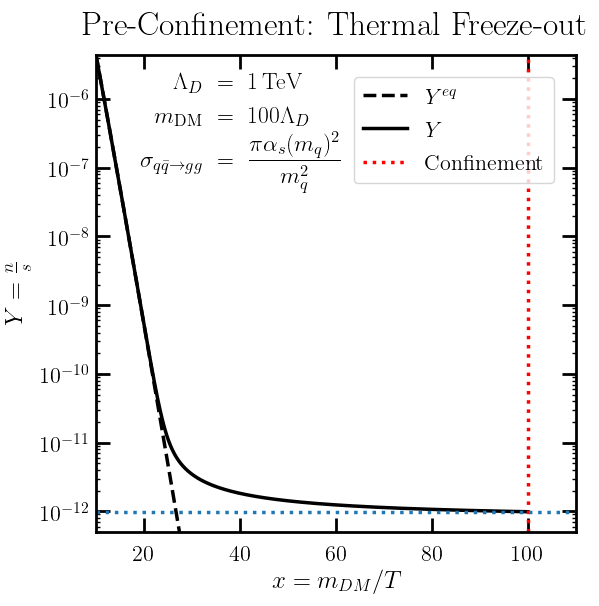

In [12]:
### Plot the results ###
plt.figure()
ax = plt.gca()
ax.set_yscale('log')
xtmp = 10**np.arange(np.log10(xinit), np.log10(mq/LambdaD), .01)
plt.plot(xtmp, ct.Yeq(2, mq, xtmp, LambdaD, Nc), color='k', linestyle='--', label=r'$Y^{eq}$')
plt.plot(x_vec, sym,      color='k',    linestyle='solid', label=r'$Y$')


plt.xlabel(r'$x = m_{DM}/T$')
plt.ylabel(r'$Y = \frac{n}{s}$')

txt = r"\begin{eqnarray*}" + \
    r"\Lambda_D &=& 1\,\mathrm{TeV} \\" + \
    r"m_{\mathrm{DM}} &=& 100 \Lambda_D \\" + \
    r"\sigma_{q\bar{q} \to gg} &=& \frac{\pi\alpha_s(m_q)^2}{m_q^2}" + \
    r"\end{eqnarray*}"
# txt = r"$\Lambda_D = 1\,$TeV, $m_{\mathrm{DM}} = 40 \Lambda_D$"
ax.text(40, 3e-7, txt,
         {'color': 'black', 'fontsize': 17, 'ha': 'center', 'va': 'center'})
          #'bbox': dict(boxstyle="round", fc=(.5,.5,.5,.02), ec="black", pad=0.33)})

plt.axvline(mq/LambdaD, color='red', linestyle=':', label='Confinement')
plt.title(r'Pre-Confinement: Thermal Freeze-out')#, $q\bar{q} \to gg$')
leg = plt.legend(loc=1)
plt.axhline(5*LambdaD**3/(sigmav * ct.Mpl * mq/20)/ct.s(LambdaD, LambdaD, Nc), linestyle=':')
offset=.5
plt.axis([xinit*.99, mq/LambdaD*1.1, sym[-1]*(1-offset), np.exp(init_cond[0]*(1-0*offset))])
# plt.savefig('/Users/gregoryridgway/Desktop/Composite DM/FO_40.pdf')

# Compression Calculation

In [21]:
LambdaD = 1e12
ratio   = 1e3
mq      = ratio * LambdaD

In [14]:
pouya_check=False

log10Lambdas = np.log10(
    np.flipud([300000, 200000, 100000, 50000, 30000, 20000, 10000, 5000, 3000, 
     2000, 1000, 500, 300, 200, 100, 50])) + 9

log10ratios = np.log10(np.flipud([100000, 50000, 30000, 20000, 10000, 
                   5000, 3000, 2000, 1000, 500, 300, 200]))

In [15]:
#Define the interactions to be included in each equation
collision_list = {
    'q' :[
        ['q','bq','g','g'], ['q','bqq','bq','g'], ['q','bB','bqq','g'], ['q','bB','bq','bq'],
        ['q','q','qq','g'], ['q','qq','B','g'], ['q','B','qq','qq'],
        ['B','bqq','q','g'], ['qq','bq','q','g'], ['B','bq','q','q'],
        ['B','bB','q','bq'], ['qq','bqq','q','bq'], ['qq','bB','q','bqq']],  
    'qq':[
        ['qq','bq','q','g'], ['qq','bqq','g','g'], ['qq','bqq','q','bq'], ['q','bB','bq','g'],
        ['qq','q','B','g'], ['q','B','qq','qq'], 
        ['q','q','qq','g'],
        ['B','bq','qq','g'], ['B','bB','qq','bqq'], ['bB','qq','bqq','q'],
        ['B','bq','qq','bq']],
    'B':[
        ['B','bq','qq','g'], ['B','bq','q','q'], ['B','bqq','q','g'], ['B','bqq','qq','bq'],
        ['B','bB','g','g'], ['B','bB','q','bq'], ['B','bB','qq','bqq'],
        ['q','qq','B','g'], ['q','B','qq','qq']]
}

weights = {'q':[-1, -1, -1, -1, 
                -2, -1, -1, 
                1, 1, 1, 
                1, 1, 1],
            'qq':[
                -1, -1, -1, -1, 
                -1, 2, 1, 
                1, 1, -1, 
                1],
            'B':[
                -1, -1, -1, -1, 
                -1, -1, -1, 
                1, -1]
}

In [16]:
%autoreload
# Critical Temperature, hubble at Tc, and entropy at Tc
def get_compression_init(mq, LambdaD, Nc):
    Tc = LambdaD
    Hc = ct.hubble(Tc,True,LambdaD,Nc)
    sc = ct.s(Tc, LambdaD, Nc)

    sigmav = ct.xsec(mq, LambdaD, Nc, 'qbq_gg')

    # initial conditions
    xinit = 10
    lnx_vec = np.arange(np.log(xinit), np.log(mq/LambdaD), .0005)
    init_cond = np.array(np.log(ct.Yeq(2, mq, xinit, LambdaD, Nc)*1.001))
    Y_fo = ct.get_history(init_cond, lnx_vec, mq, sigmav, LambdaD, Nc, gDM=2)[-1]
    n_fo = Y_fo*sc
#     print(n_fo/(phys.hbar*phys.c)**3)
    

#     if pouya_check:
    R_1 = 10**(-8/3)*(ct.Mpl/Tc)**(2/3)/(LambdaD)
#     else:
#     R_1 = (100*Tc*Hc**2)**(-1/3)

    RLinit = R_1 * LambdaD
    logy_init = np.log(RLinit)
    Rinit   = RLinit/LambdaD
    Vinit   = 4*np.pi*Rinit**3/3
#     print(LambdaD/n_fo**(1/3))
    return (R_1, n_fo * Vinit, Y_fo)
    
    
print('Nq_init: ', get_compression_init(mq, LambdaD, Nc)[1])

Nq_init:  [1.53379572e+13]


In [17]:
def get_suppression(ratio, LambdaD, Nc,
                    pre_init=None, offset = 1e3, 
                    rtol_init=1e-2, rtol=1e-6):
    
    mq = ratio*LambdaD
    if pouya_check:
        v_b = 1/np.sqrt(ratio)
    else:
        v_b = 1/np.sqrt(ratio/2)
    
    R_1, Nq_init, Y_fo = get_compression_init(mq, LambdaD, Nc)
    yinit = np.log(R_1*LambdaD)
    y_vec = np.arange(yinit, 0, -.01)

    init = ct.get_init(
        collision_list, weights, mq, 
        LambdaD, Nc, 
        Nq_init, yinit+np.log(offset), yinit, pre_init,
        mxstep = 10000, rtol=rtol_init, pion=False
    )
    
    if np.any(np.isnan(init)):
        print('Bad init')
        raise ValueError('Bad init! '+str(init))
    init[0] = np.log(Nq_init)

    soln = ct.get_B(y_vec, init, collision_list, weights, 
                 mq, LambdaD, Nc, mxstep = 1000, rtol=rtol,
                   pion = False)

    if np.any(np.isnan(soln)):
        print('nan in soln')
        raise ValueError('nan, son!')

    #     red_func = interp1d(y_vec,np.exp(soln[:,0])/Nq_init, kind='cubic')
    #     green_func = interp1d(y_vec,np.exp(soln[:,1])/Nq_init, kind='cubic')
    black_func = interp1d(y_vec,np.exp(soln[:,2])/Nq_init, kind='cubic')

    vs = ct.vw(np.exp(y_vec)/LambdaD,LambdaD,Nc)
    esc_func = interp1d(y_vec,
                        v_b/vs * (np.exp(soln[:,2]))/Nq_init, 
                        kind='cubic')
    suppress = quad(esc_func, y_vec[-1], y_vec[0])[0]*9
    if (suppress<0) | (suppress>1):
        print(suppress)
        raise ValueError('suppression negative or greater than 1')
        
    if suppress < 1/np.sqrt(Nq_init[0]):
        print('asym!')
        suppress = 1/np.sqrt(Nq_init[0])
    
    return Nq_init[0], suppress

In [22]:
%autoreload
# ratio = 1e3
# LambdaD=1e12
# mq = ratio*LambdaD

v_b = 1/np.sqrt(ratio/2)

R_1, Nq_init, Y_fo = get_compression_init(mq, LambdaD, Nc)
# R_1 = 5.4e9*(LambdaD/1e12)**(-.915)
yinit = np.log(R_1*LambdaD)
y_vec = np.arange(yinit, 0, -.01)

# Nq_init=10*Nq_init

init = ct.get_init(mq, LambdaD, Nc, Nq_init, yinit)
# init = ct.OLDget_init(
#     collision_list, weights, mq, 
#     LambdaD, Nc, 
#     Nq_init, yinit,#+np.log(1e1), 
#     yinit, None,
#     mxstep = 10000, rtol=1e-6, pion=False
# )

if np.any(np.isnan(init)):
    print('Bad init')
    raise ValueError('Bad init! '+str(init))
init[0] = np.log(Nq_init)

soln = ct.get_B(y_vec, init, collision_list, weights, 
             mq, LambdaD, Nc, mxstep = 1000, rtol=1e-6,
               pion = False)

red_func = interp1d(y_vec,np.exp(soln[:,0])/Nq_init, kind='cubic')
green_func = interp1d(y_vec,np.exp(soln[:,1])/Nq_init, kind='cubic')
black_func = interp1d(y_vec,np.exp(soln[:,2])/Nq_init, kind='cubic')

In [39]:
engLs = {part: ct.engL(mq, LambdaD, part) for part in ct.inds}
mLs   = {part: ct.mL(mq, LambdaD, part) for part in ct.inds}
log_eq_fac_qq = (
    engLs['qq']-2*engLs['q'] +
    np.log(4*np.pi/3) +
    -3/2*np.log(2 * np.pi) + 3*np.log(mLs['q']) - 3/2*np.log(mLs['qq']) +
    np.log(ct.gs['q']**2/ct.gs['qq'])
)

log_eq_fac_B = (
    engLs['B']-engLs['qq']-engLs['q'] +
    np.log(4*np.pi/3) +
    -3/2*np.log(2 * np.pi) + 3/2*np.log(mLs['q']) + 3/2*np.log(mLs['qq']) 
    - 3/2*np.log(mLs['B']) +
    np.log(ct.gs['q']*ct.gs['qq']/ct.gs['B'])
)
log_eq_fac_B = (
    engLs['qq']-engLs['B']-engLs['bq'] +
    np.log(4*np.pi/3) +
    -3/2*np.log(2 * np.pi) + 3/2*np.log(mLs['B']) + 3/2*np.log(mLs['bq']) 
    - 3/2*np.log(mLs['qq']) +
    np.log(ct.gs['bq']*ct.gs['B']/ct.gs['qq'])
)

log_eq_fac_B2 = (
    2*engLs['qq']-engLs['q']-engLs['B'] +
    3/2*np.log(mLs['q']) + 3/2*np.log(mLs['B']) - 3*np.log(mLs['qq'])+
    np.log(ct.gs['q']*ct.gs['B']/ct.gs['qq']**2)
)

In [24]:
esc_func = interp1d(y_vec,
                    v_b/1e-3*(np.exp(soln[:,2]))/Nq_init, 
                    kind='cubic')
suppress = quad(esc_func, y_vec[-1], y_vec[0])[0]*9

# y when the quark pressure takes over
ind_p = sum(25*np.exp(soln[:,0]-2*y_vec[0:])/(4*np.pi/3)<1)
yp = y_vec[ind_p]

Text(20000.0, 2e-19, '\\begin{eqnarray*}\\Lambda &=& 1\\mathrm{TeV} \\\\m_q &=& 1000 \\Lambda \\\\v_w &=& 10^{-3}\\end{eqnarray*}')

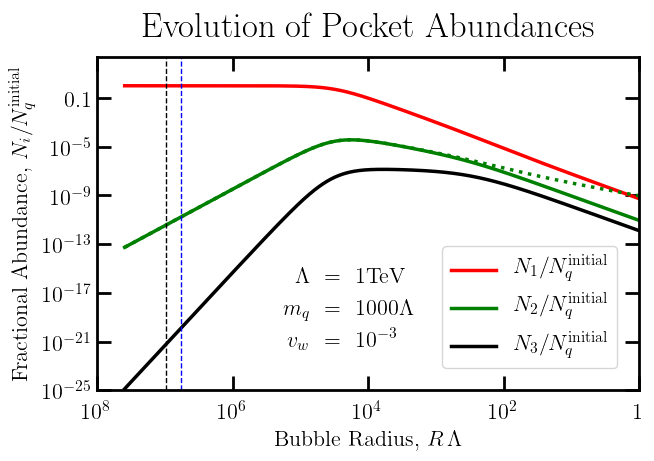

In [40]:
plt.figure(figsize=(7,7*2/(1+np.sqrt(5))))
plt.loglog()
plt.axis([1e8,1,1e-25,220.5])
plt.plot(np.exp(y_vec[0:]), np.exp(soln[:,0])/Nq_init, color='red', label=r'$N_1/N_q^{\mathrm{initial}}$')
# plt.plot(np.exp(y_vec[0:]), np.exp(2*y_vec[0:])*7e-10, color='red', linestyle=':')
plt.plot(np.exp(y_vec[0:]), np.exp(soln[:,1])/Nq_init, color='green', label=r'$N_2/N_q^{\mathrm{initial}}$')
# plt.plot(np.exp(y_vec[0:400]), np.exp(-3*y_vec[0:400])*5e9, color='green', linestyle=':')
N2_ana = (Nq_init*red_func(y_vec))**2/np.exp(log_eq_fac_qq+3*y_vec)
plt.plot(np.exp(y_vec), N2_ana/Nq_init, color='green', linestyle=':')

plt.plot(np.exp(y_vec[0:]), np.exp(soln[:,2])/Nq_init, color='k', label=r'$N_3/N_q^{\mathrm{initial}}$')
# plt.plot(np.exp(y_vec[0:]), np.exp(-6*y_vec[0:])*5e20, color='k', linestyle=':')
plt.plot(np.exp(y_vec[0:]), N2_ana*red_func(y_vec[0:])/np.exp(log_eq_fac_B+3*y_vec), color='k', linestyle=':')
plt.plot(np.exp(y_vec[0:]), (N2_ana/Nq_init)**2/red_func(y_vec[0:])*np.exp(log_eq_fac_B2), 
         color='purple', linestyle=':')
# plt.plot(np.exp(y_vec[0:]), N2_ana/Nq_init**2/red_func(y_vec[0:])*np.exp(log_eq_fac_B), 
#          color='purple', linestyle=':')
plt.xlabel(r'Bubble Radius, $R \, \Lambda$', fontsize=16)
plt.ylabel(r'Fractional Abundance, $N_i/N_q^{\mathrm{initial}}$', fontsize=16)
plt.title(r'Evolution of Pocket Abundances', fontsize=25)
plt.legend()

# plt.axhline(Nq_init/np.exp(log_eq_fac))
plt.axvline(np.exp(yp), color='k', linestyle='--', linewidth=1.0)
plt.axvline(np.exp(yp-.5), color='blue', linestyle='--', linewidth=1.0)
# plt.axvline(252, color='k', linestyle='--', linewidth=1.0)
# plt.axvline(6830.522038913273, color='k', linestyle='--', linewidth=1.0)


txt = r"\begin{eqnarray*}" + \
    r"\Lambda &=& 1\mathrm{TeV} \\" + \
    r"m_q &=& 1000 \Lambda \\" + \
    r"v_w &=& 10^{-3}" + \
    r"\end{eqnarray*}"

ax=plt.gca()
ax.text(2e4, 2e-19, txt,
         {'color': 'black', 'fontsize': 16, 'ha': 'center', 'va': 'center'})#, bbox=dict(fc="none"))
# plt.savefig('/Users/gregoryridgway/Dropbox (MIT)/Strong_DM/Draft/figures/abundance_example.pdf')

In [36]:
indd=800

good_approx, dNq_dt, logNs = ct.get_simple_Ns(
    ct.boltz_coll_list, ct.boltz_weights, np.exp(soln[indd,0]), y_vec[indd], mq, 
    LambdaD, Nc, .001, mLs, engLs, logxsec_list
)

['B', 'bq', 'qq', 'g'] 30.194946375160853
['B', 'bq', 'q', 'q'] 30.194946375160853
['B', 'bqq', 'q', 'g'] 0.0066877290858315
['B', 'bqq', 'qq', 'bq'] 0.0066877290858315
['B', 'bB', 'g', 'g'] 6.625961833971507e-05
['B', 'bB', 'q', 'bq'] 6.625961833971507e-05
['B', 'bB', 'qq', 'bqq'] 6.625961833971507e-05
['q', 'qq', 'B', 'g'] [0.]
['q', 'B', 'qq', 'qq'] 0.30194946375165443
[0.]
Not dominant


In [573]:
np.log10(np.exp(yp))

5.914724465256541

In [561]:
Nq_init

array([1.15260356e+11])

In [559]:
sol=soln
state='B'

for ii in np.arange(ind_p,len(y_vec)-ind_p):
    v_w=.001
    v_w= 1/2 * sum([weight*ct.collision(coll, sol[ii], y_vec[ii], 
                        mq, LambdaD, Nc, 'q', 1, mLs, engLs, logxsec_list)
                       for coll, weight in zip(collision_list['q'], weights['q'])])
#     print(v_w)
    
    goods = [weight*ct.collision(coll, sol[ii], y_vec[ii], 
        mq, LambdaD, Nc, state, v_w, mLs, engLs, logxsec_list)
        for coll, weight in zip(collision_list[state], weights[state])
    ]
    ind = np.argmax(np.abs(goods))
    tmp = np.delete(goods,ind)
    esc = 3*(v_b+v_w)/v_w*np.exp(sol[ii,2]-y_vec[ii])
    
# Is the greatest rate the majority of the rates?
#     print(ii, np.exp(y_vec[ii]), goods[ind]/np.sum(np.abs(goods)))
    
#Is the second greatest rate comparable?
#     print(ii, np.exp(y_vec[ii]), tmp[np.argmax(np.abs(tmp))]/goods[ind])
    
#     print(np.exp(y_vec[ii]), np.argmax(np.abs(goods)))

# Is the total rate large compared to 1? That's when the red line turns down
#     print(np.exp(y_vec[ii]), np.sum(goods))

# Is the escape rate large?
#     print(ii, np.exp(y_vec[ii]), v_w, goods[ind]/esc)

    Tc=LambdaD
    print(np.exp(y_vec[ii]), v_w/np.exp(y_vec[ii])/(ct.hubble(Tc,True,LambdaD,Nc)/LambdaD))
    

821721.1499654399 [0.19197006]
813544.8879114592 [0.19781634]
805449.9810242258 [0.20384066]
797435.6198063055 [0.21004845]
789501.0028148978 [0.21644529]
781645.3365816912 [0.22303694]
773867.835533516 [0.22982933]
766167.7219137863 [0.23682858]
758544.225704723 [0.24404098]
750996.5845503525 [0.25147302]
743524.0436802697 [0.25913139]
736125.8558341603 [0.26702298]
728801.2811870747 [0.2751549]
721549.5872754442 [0.28353447]
714370.0489238345 [0.29216923]
707261.9481724275 [0.30106695]
700224.5742052248 [0.31023563]
693257.2232789649 [0.31968353]
686359.1986527492 [0.32941916]
679529.8105183666 [0.33945127]
672768.3759313128 [0.34978889]
666074.2187424941 [0.36044133]
659446.6695306135 [0.37141818]
652885.0655352266 [0.38272931]
646388.7505904658 [0.39438491]
639957.0750594233 [0.40639545]
633589.3957691861 [0.41877176]
627285.0759465187 [0.43152498]
621043.4851541852 [0.44466657]
614863.9992279051 [0.45820837]
608746.0002139361 [0.47216257]
602688.8763072786 [0.4865417]
596692.02179

33495.1651282312 [2797.46418099]
33161.88266660624 [2881.89661988]
32831.91642088293 [2968.86170946]
32505.233394161733 [3058.43461796]
32181.80091786774 [3150.69271513]
31861.586648483782 [3245.71562186]
31544.55856431609 [3343.58527165]
31230.684962292045 [3444.38599168]
30919.93445478989 [3548.20454271]
30612.27596649991 [3655.13021561]
30307.678731316893 [3765.25485148]
30006.112289263496 [3878.6730285]
29707.5464834442 [3995.48204479]
29411.951457029616 [4115.7818823]
29119.29765027078 [4239.67558697]
28829.55579754313 [4367.26913404]
28542.696924419946 [4498.67144473]
28258.692344774863 [4633.99465247]
27977.51365791325 [4773.35417475]
27699.132745732095 [4916.86861802]
27423.521769908206 [5064.66006462]
27150.653169114314 [5216.85408555]
26880.499656262957 [5373.57987725]
26613.034215777716 [5534.9700485]
26348.23010089165 [5701.16141466]
26086.060830972612 [5872.29452259]
25826.500188875125 [6048.51391614]
25569.522218318678 [6229.96824412]
25315.101221292072 [6416.81034467]
25

1788.5426100319485 [3354659.74717823]
1770.746313715434 [3400867.57041102]
1753.127093505918 [3447513.88159826]
1735.6831874666968 [3494601.89931428]
1718.4128511926297 [3542134.89920139]
1701.3143576356972 [3590116.21294967]
1684.385996932295 [3638549.22710186]
1667.6260762322456 [3687437.38167983]
1651.0329195295126 [3736784.16862522]
1634.6048674945978 [3786593.1300485]
1618.340277308608 [3836915.26700609]
1602.23752249897 [3887782.14273344]
1586.2949927767845 [3939029.93509595]
1570.5110938757937 [3990712.73504634]
1554.884247392954 [4042913.80233777]
1539.4128906305946 [4095627.4145614]
1524.0954764401467 [4148845.77887778]
1508.9304730674266 [4202526.55998577]
1493.9163639994597 [4256735.25045804]
1479.051647812827 [4311431.13089473]
1464.3348380235227 [4366595.55194812]
1449.764462938304 [4422297.4347841]
1435.33906550752 [4478551.64966265]
1421.0572031794068 [4535293.06882692]
1406.9174477558297 [4592583.72907102]
1392.9183852494632 [4650410.83550174]
1379.0586157423909 [470877

101.40844613113542 [77723471.66306639]
100.39941523289211 [78521405.51167873]
99.40042435983854 [79327315.36075613]
98.41137361205493 [80141276.5586533]
97.43216408364226 [80963366.42217773]
96.46269785283171 [81793662.96307954]
95.50287797219228 [82632244.89425305]
94.55260845893608 [83479191.63599154]
93.61179428531986 [84334583.32233174]
92.68034136914227 [85198500.80745386]
91.75815656433547 [86071025.67215826]
90.84514765165048 [86952240.23042499]
89.9412233294352 [87842227.536032]
89.04629320450414 [88741082.95763999]
88.16026778309902 [89648873.84220031]
87.28305846193933 [90565693.48136641]
86.41457751936197 [91491628.08269718]
85.55473810654892 [92426764.64210196]
84.7034542388424 [93371190.95182766]
83.8606407871462 [94324995.60852492]
83.02621346941281 [95288268.02146186]
82.20008884221511 [96261098.42082143]
81.38218429240193 [97243577.86615232]
80.57241802883671 [98235798.25491442]
79.77070907421826 [99237852.33116299]
78.97697725698306 [1.00249843e+08]
78.19114320328792 [

4.0517803732921776 [1.84679554e+09]
4.011464484966063 [1.86475191e+09]
3.9715497464313434 [1.8828841e+09]
3.932032166180903 [1.90119387e+09]
3.892907792423785 [1.91968299e+09]
3.85417271269001 [1.93835326e+09]
3.8158230534393254 [1.95720648e+09]
3.7778549796738474 [1.97624449e+09]
3.7402646945545603 [1.99546891e+09]
3.703048439021626 [2.01488175e+09]
3.6662024914184776 [2.03448488e+09]
3.6297231671196504 [2.05428021e+09]
3.593606818162314 [2.07426963e+09]
3.557849832881477 [2.09445509e+09]
3.5224486355488125 [2.11483852e+09]
3.4873996860150864 [2.13542189e+09]
3.452699479356138 [2.15620719e+09]
3.418344545522384 [2.17719643e+09]
3.3843314489918126 [2.19839162e+09]
3.350656788426426 [2.21979487e+09]
3.317317196332105 [2.24140831e+09]
3.284309338721857 [2.26323409e+09]
3.2516299147824155 [2.28527437e+09]
3.219275656544153 [2.3075313e+09]
3.187243328554283 [2.33000702e+09]
3.1555297275533136 [2.35270367e+09]
3.124131682154716 [2.37562356e+09]
3.0930460525277863 [2.39876866e+09]
3.06226973

In [570]:
10**(3*5.4-5)/Nq_init

array([1.37505492])

In [28]:
ii=556
state='B'
v_w = 1e-3
process_ind = {'qbq_gg': 0, 'qq_qqg': 1, 'qqq_Bg': 2, 'other': 3}
logxsec_list = {process: np.log(ct.xsec(mq, LambdaD, Nc, process)) for process in process_ind}
v_b = np.sqrt(2/ct.mL(mq, LambdaD, 'B'))


goods = [weight*ct.collision(coll, soln[ii], y_vec[ii], 
                             mq, LambdaD, Nc, state, v_w, mLs, engLs, logxsec_list)
          for coll, weight in zip(collision_list[state], weights[state])]

if state == 'B':
    print("v_b ", 3*(v_b+v_w)/v_w*np.exp(soln[ii,2]-y_vec[ii]))
for coll, good in zip(collision_list[state], goods):
    print(coll, good)
    
np.sum(goods)

v_b  0.24836218469491048
['B', 'bq', 'qq', 'g'] 1.4312470785887623
['B', 'bq', 'q', 'q'] 1.4312470785887623
['B', 'bqq', 'q', 'g'] 1.3227828432665428e-06
['B', 'bqq', 'qq', 'bq'] 1.3227828432665428e-06
['B', 'bB', 'g', 'g'] 4.49934314476458e-11
['B', 'bB', 'q', 'bq'] 4.49934314476458e-11
['B', 'bB', 'qq', 'bqq'] 4.49934314476458e-11
['q', 'qq', 'B', 'g'] [-46.91263615]
['q', 'B', 'qq', 'qq'] -0.29097453057176126


array([-44.34111388])

$$
dE_q = p_q dV = n_q T 4 \pi R^2 dR \\
dE = \sigma dA = .02 T_c^3 8 \pi R dR \\
$$

implies
$$
n_q R = .04 T_c^2 \\
N_q/R^2 = const.
$$

And 
$$
\frac{d}{dt}(N_q/R^2) = 0 \\
v_w N_q \frac1{R^3} = \frac1{2 R^2}\frac{dN_q}{dt} \\
v_w =  \frac12 R\frac{d\ln(N_q)}{dt} \\
v_w =  -\frac12 v_w\frac{d\ln(N_q)}{d\ln(R)} \\
$$

Text(20000.0, 2e-19, '\\begin{eqnarray*}\\Lambda &=& 1\\mathrm{TeV} \\\\m_q &=& 1000 \\Lambda \\\\v_w &=& 10^{-3}\\end{eqnarray*}')

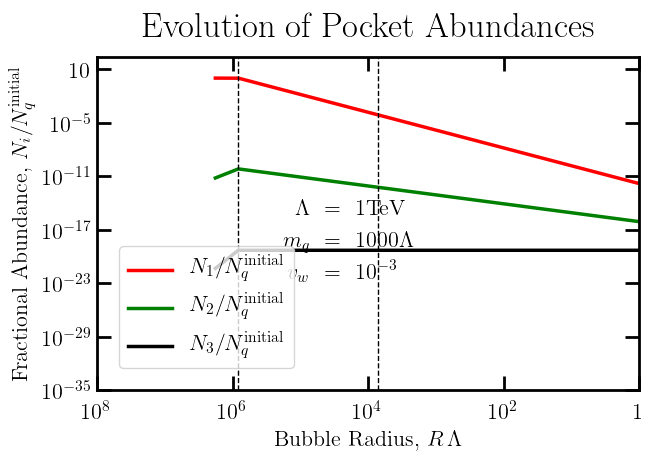

In [547]:
squeeze=y_vec[ind_p:]-y_vec[ind_p]

soln2=np.transpose([
    np.append(soln[:ind_p,0], np.log(Nq_init) + 2*squeeze),
    np.append(soln[:ind_p,1], soln[ind_p,1] + squeeze),
    np.append(soln[:ind_p,2], soln[ind_p,2] + np.zeros_like(squeeze))
])

plt.figure(figsize=(7,7*2/(1+np.sqrt(5))))
plt.loglog()
plt.axis([1e8,1,1e-35,220.5])
plt.plot(np.exp(y_vec[0:]), np.exp(soln2[:,0])/Nq_init, color='red', label=r'$N_1/N_q^{\mathrm{initial}}$')
plt.plot(np.exp(y_vec[0:]), np.exp(soln2[:,1])/Nq_init, color='green', label=r'$N_2/N_q^{\mathrm{initial}}$')
plt.plot(np.exp(y_vec[0:]), np.exp(soln2[:,2])/Nq_init, color='k', label=r'$N_3/N_q^{\mathrm{initial}}$')
plt.xlabel(r'Bubble Radius, $R \, \Lambda$', fontsize=16)
plt.ylabel(r'Fractional Abundance, $N_i/N_q^{\mathrm{initial}}$', fontsize=16)
plt.title(r'Evolution of Pocket Abundances', fontsize=25)
plt.legend()

# plt.axhline(Nq_init/np.exp(log_eq_fac))
plt.axvline(np.exp(yp), color='k', linestyle='--', linewidth=1.0)
plt.axvline(7109.280931459488, color='k', linestyle='--', linewidth=1.0)

txt = r"\begin{eqnarray*}" + \
    r"\Lambda &=& 1\mathrm{TeV} \\" + \
    r"m_q &=& 1000 \Lambda \\" + \
    r"v_w &=& 10^{-3}" + \
    r"\end{eqnarray*}"

ax=plt.gca()
ax.text(2e4, 2e-19, txt,
         {'color': 'black', 'fontsize': 16, 'ha': 'center', 'va': 'center'})#, bbox=dict(fc="none"))

In [ ]:
# Measure everything in units of Tc
Tc    = 1
L, mu, kappa = 1.413*Tc**4, 0.02*Tc**3, 7*10**-5
rho = np.pi**2/30*106.75 * Tc**4

# The only other scale is Mpl, so it is  
# the only quantity that changes with Tc. 
# e.g. if Tc = 10 TeV, Mpl =  1.220910e15/np.sqrt(8*np.pi/3)

# Define Mpl = (G 8 pi /3)^-1/2
Mpl   = 1.220910e16/np.sqrt(8*np.pi/3)
H    = np.sqrt(rho)/Mpl
dt   = 1e-6/H;

In [ ]:
# Second Half of the Phase Transition: Pocket Contraction #
Ts     = np.array([T[-1]])
xs     = np.array([0.5])

R1 = 10**(-8/3) * (Mpl/Tc)**(2/3)
n_pocket = 3/(8*np.pi * R1**3)
Rs = np.array([R1])
times = np.array([0])

k=0
# while Rs[-1]>0:
while k<1000:
    
    H  = np.sqrt(rho)*Ts[-1]**2/Mpl
    vw =

    Ts = np.append(Ts, Ts[k]*(1 - dt*H))

    xs = np.append(xs, 1-4*np.pi*Rs[-1]**3/3 * n_pocket)
    Rs = np.append(Rs, Rs[-1] - vw*dt)

    # Injected heat
    Ts[k+1] += L/(4*rho/Tc) * (x2[k+1] - x2[k])

    times = np.append(times, times[-1] + dt)
    k+=1

Text(0.5, 1.0, 'Does Quark Pressure Matter? (Yes)')

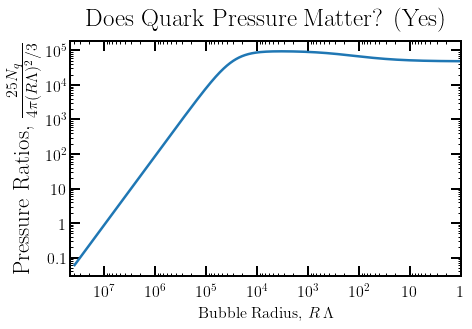

In [154]:
plt.figure(figsize=(7,7*2/(1+np.sqrt(5))))
plt.xlim([R_1*LambdaD*1.2,1])
ax = plt.gca()
ax.loglog()
plt.plot(np.exp(y_vec[0:]), 25*np.exp(soln[:,0]-2*y_vec[0:])/(4*np.pi/3))
plt.xlabel(r'Bubble Radius, $R \, \Lambda$', fontsize=16)
plt.ylabel(r'Pressure Ratios, $\frac{25 N_q}{4 \pi (R \Lambda)^2/3}$', fontsize=23)
plt.title(r'Does Quark Pressure Matter? (Yes)', fontsize=25)
# plt.legend()

# txt = r"\begin{eqnarray*}" + \
#     r"\Lambda &=& 1\mathrm{TeV} \\" + \
#     r"m_q &=& 1000 \Lambda \\" + \
#     r"v_w &=& 10^{-3}" + \
#     r"\end{eqnarray*}"

# ax=plt.gca()
# ax.text(5e2, 1e-8, txt,
#          {'color': 'black', 'fontsize': 16, 'ha': 'center', 'va': 'center'})

Text(0.5, 1.0, 'Number of Annihilations per Hubble Time')

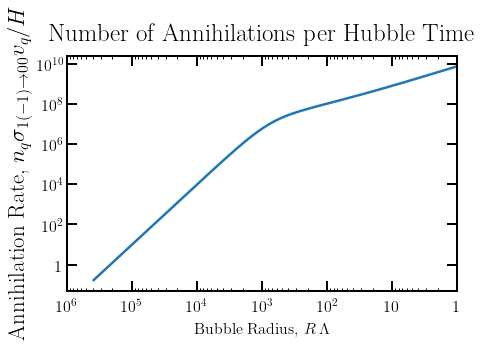

In [70]:
Mpl   = 1.220910e19/np.sqrt(8*np.pi/3)*1e12 # eV
rho = np.pi**2/30*106.75 * LambdaD**4
H    = np.sqrt(rho)/Mpl

nq = Nq_init*red_func(y_vec[0:])/np.exp(y_vec[0:])**3/4/np.pi*LambdaD**3


Mpl   = 1.220910e19/np.sqrt(8*np.pi/3)*1e12 # eV
rho = np.pi**2/30*106.75 * LambdaD**4
H    = np.sqrt(rho)/Mpl

nq = Nq_init*red_func(y_vec[0:])/np.exp(y_vec[0:])**3/4/np.pi*LambdaD**3


plt.figure(figsize=(7,7*2/(1+np.sqrt(5))))
# plt.axis([1e7,1,1e-25,22.5])
plt.xlim([1e6,1])
ax = plt.gca()
ax.loglog()
plt.plot(np.exp(y_vec[0:]), nq*ct.xsec(mq, LambdaD, 3, 'qbq_gg')*np.sqrt(LambdaD/mq)/H)
plt.xlabel(r'Bubble Radius, $R \, \Lambda$', fontsize=16)
plt.ylabel(r'Annihilation Rate, $n_q \sigma_{1(-1)\to 00} v_q/H$', fontsize=23)
plt.title(r'Number of Annihilations per Hubble Time', fontsize=25)

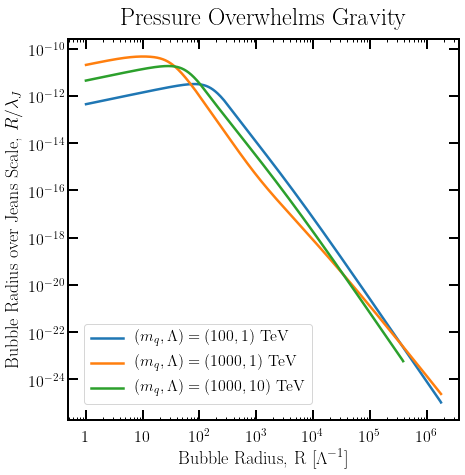

In [68]:
Rs = np.exp(y_vec[0:])/LambdaD
M_b = Nq_init*black_func(y_vec[0:])*3*mq
rhos = M_b/(4*np.pi/3 * Rs**3)
lam_J = v_b/np.sqrt(rhos/ct.Mpl**2)
data_3 = [np.exp(y_vec[0:]), Rs/lam_J]

plt.figure(figsize=(7,7))
plt.loglog()
plt.plot(data_1[0], data_1[1], #color='k', 
         label=r'$(m_q, \Lambda) = (100, 1)$ TeV')
plt.plot(data_2[0], data_2[1], #color='k', 
         label=r'$(m_q, \Lambda) = (1000, 1)$ TeV')
plt.plot(data_3[0], data_3[1], #color='k', 
         label=r'$(m_q, \Lambda) = (1000, 10)$ TeV')
plt.title('Pressure Overwhelms Gravity')
plt.ylabel(r'Bubble Radius over Jeans Scale, $R/\lambda_J$')
plt.xlabel(r'Bubble Radius, R [$\Lambda^{-1}$]')
plt.legend()

plt.savefig('/Users/gregoryridgway/Desktop/Composite DM/Jeans_Estimate.png')

## Scan

In [ ]:
def get_target(mDM):
    n0= phys.rho_DM/mDM
    s0=ct.s(T=phys.TCMB(1), LambdaD=LambdaD, Nc=Nc)/(phys.hbar*phys.c)**3
    return n0/s0

In [388]:
def get_relic(ratio,LambdaD,Nc,pre_init=None):
    mq = ratio*LambdaD
    
    Tc = LambdaD
    Hc = ct.hubble(Tc,True,LambdaD,Nc)
    sc = ct.s(Tc, LambdaD, Nc)

    sigmav = ct.xsec(mq, LambdaD, Nc, 'qbq_gg')

    # initial conditions
    xinit = 10
    lnx_vec = np.arange(np.log(xinit), np.log(mq/LambdaD), .0005)
    init_cond = np.array(np.log(ct.Yeq(2, mq, xinit, LambdaD, Nc)*1.001))
    Y_fo = ct.get_history(init_cond, lnx_vec, mq, sigmav, LambdaD, Nc, gDM=2)[-1]
    n_fo = Y_fo*sc
    
    suppress = get_suppression(ratio, LambdaD, Nc, 
                    pre_init=pre_init, offset = 1e3, 
                    rtol_init=1e-6, rtol=1e-6)[1]
    
    redshift = ct.s(T=phys.TCMB(1), LambdaD=LambdaD, Nc=Nc)/sc
    
    
    return Y_fo * suppress #* redshift

In [389]:
%autoreload
ratio = 1e2
LambdaD=1e14*.5958
target = get_target(mDM=ratio*LambdaD)
relic = get_relic(ratio,LambdaD,Nc)

print(relic/target)

0.0001
asym!
0.9996710643750417


In [391]:
# %%prun
%autoreload
pouya_check=False

log10Lambdas = np.arange(np.log10(1e14*.5958), 11, -0.1)
data = np.zeros(log10Lambdas.size)

log10guess=2

step=0.1
offset=1e3
for ii, LambdaD in enumerate(tqdm(10**log10Lambdas)):
    print("\nlog10LambdaD:", np.log10(LambdaD),'\n')
    
    bad_flag=False
    pre_init=None
    
    below=False
    above=False
    
    while ((not below) | (not above)) & (not bad_flag):#ii==0 | True:
        ratio = 10**log10guess
        print("log10 mq/LambdaD:", np.log10(ratio))

        try:
            mq = ratio*LambdaD
            target = get_target(mDM=3*mq)
            R_1, Nq_init, Y_fo = get_compression_init(mq, LambdaD, Nc)
            yinit = np.log(R_1*LambdaD)
            pre_init = ct.get_init(
                collision_list, weights, mq, 
                LambdaD, Nc, 
                Nq_init, yinit+np.log(offset), yinit+np.log(offset-.001), 
                init=pre_init, 
                mxstep = 10000, rtol=1e-6, pion=False
            )
            relic = get_relic(ratio,LambdaD,Nc,pre_init=pre_init)
            val = relic/target

            if  val < 1:
                print('below', val)
                below = True
                log10below = [log10guess, val]
                log10guess += step

            else:
                print('above', val)
                above = True
                log10above = [log10guess, val]
                log10guess -= step

            print('Initial Nq, Suppression: ', Nq_init, suppress)
        except ValueError:
            print('break!')
            bad_flag = True
         
    #interpolation
    if not bad_flag:
        data[ii] = (1-log10below[1])/(log10above[1]-log10below[1]) * (
            (log10above[0]-log10below[0])
        ) + log10below[0]
    
    else:
        data[ii] = 0
        
#     pickle.dump((log10Lambdas,data), open(outfolder+'asym_data.p','wb'))


log10LambdaD: 13.775100498879025 

log10 mq/LambdaD: 2.0
0.0001
asym!
above 2.9990762059649883
Initial Nq, Suppression:  [5.34589192e+10] 2.4037685307455115e-06
log10 mq/LambdaD: 1.9
0.0001
asym!
above 1.6152231168243827
Initial Nq, Suppression:  [2.45759443e+10] 2.4037685307455115e-06
log10 mq/LambdaD: 1.7999999999999998
0.0001
asym!
below 0.8625181624687819
Initial Nq, Suppression:  [1.11066138e+10] 2.4037685307455115e-06

log10LambdaD: 13.675100498879026 

log10 mq/LambdaD: 1.9
0.0001
asym!
below 0.5728729214285496
Initial Nq, Suppression:  [1.23072709e+10] 2.4037685307455115e-06
log10 mq/LambdaD: 2.0
0.0001
asym!
below 0.9755377655829354
Initial Nq, Suppression:  [2.2518183e+10] 2.4037685307455115e-06
log10 mq/LambdaD: 2.1
0.0001
asym!
above 2.1825425208568734
Initial Nq, Suppression:  [7.11165366e+10] 2.4037685307455115e-06

log10LambdaD: 13.575100498879026 

log10 mq/LambdaD: 2.0
0.0001
asym!
below 0.41389230984096587
Initial Nq, Suppression:  [1.61368918e+10] 2.4037685307455115

0.0001
above 249.19239487285373
Initial Nq, Suppression:  [1.58813435e+14] 2.4037685307455115e-06

log10LambdaD: 11.375100498879034 

log10 mq/LambdaD: 3.200000000000001
0.0001
below 0.04368603105851991
Initial Nq, Suppression:  [4.96271739e+13] 2.4037685307455115e-06
log10 mq/LambdaD: 3.300000000000001
0.0001
above 8.335582972458624
Initial Nq, Suppression:  [7.91746632e+13] 2.4037685307455115e-06

log10LambdaD: 11.275100498879034 

log10 mq/LambdaD: 3.200000000000001
0.0001
below 0.07785178808098306
Initial Nq, Suppression:  [8.94838929e+13] 2.4037685307455115e-06
log10 mq/LambdaD: 3.300000000000001
0.0001
above 2.1749317195187885
Initial Nq, Suppression:  [8.18793566e+13] 2.4037685307455115e-06

log10LambdaD: 11.175100498879035 

log10 mq/LambdaD: 3.200000000000001
0.0001
below 0.09486756599990652
Initial Nq, Suppression:  [1.442819e+14] 2.4037685307455115e-06
log10 mq/LambdaD: 3.300000000000001
0.0001
above 3.251207708130959
Initial Nq, Suppression:  [1.45006086e+14] 2.403768530745

In [ ]:
pickle.dump((log10Lambdas,data), open(outfolder+'asym_data.p','wb'))

In [ ]:
log10lambdas

Text(0.5, 1.0, 'Relic Abundance Line')

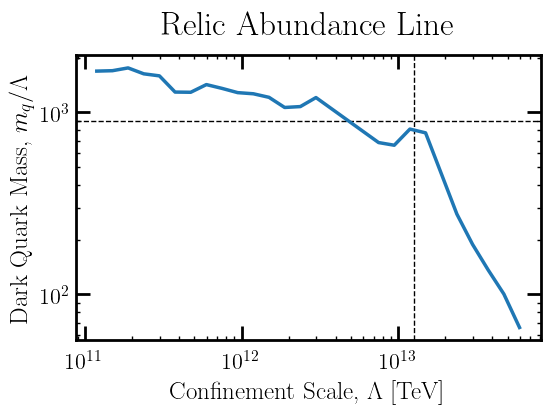

In [405]:
plt.figure(figsize=(6,6*2/(1+np.sqrt(5))))
plt.loglog()
mask = (data!=0)
plt.axhline(10**(2.95), color='k', linestyle='--', linewidth=1.0)
plt.axvline(10**(13.1), color='k', linestyle='--', linewidth=1.0)

plt.plot(10**log10Lambdas[mask], 10**data[mask])
plt.xlabel(r'Confinement Scale, $\Lambda$ [TeV]')
plt.ylabel(r'Dark Quark Mass, $m_q/\Lambda$')
plt.title(r'Relic Abundance Line')

In [567]:
# %%prun
%autoreload
pouya_check=False

Nq_info = np.zeros((log10Lambdas.size, log10ratios.size))
suppress_info = np.zeros((log10Lambdas.size, log10ratios.size))

offset=1e3
for ii, LambdaD in enumerate(tqdm(10**log10Lambdas)):
    bad_flag=False
    pre_init=None
    if True:#ii==0 | True:
        print("\nlog10LambdaD:", np.log10(LambdaD),'\n')
        for jj, ratio in enumerate(10**log10ratios):
            if not bad_flag:
                print("log10 mq/LambdaD:", np.log10(ratio))

                try:
                    mq = ratio*LambdaD
                    R_1, Nq_init, Y_fo = get_compression_init(mq, LambdaD, Nc)
                    yinit = np.log(R_1*LambdaD)
                    pre_init = ct.get_init(
                        collision_list, weights, mq, 
                        LambdaD, Nc, 
                        Nq_init, yinit+np.log(offset), yinit+np.log(offset-.001), 
                        init=pre_init, 
                        mxstep = 10000, rtol=1e-3, pion=False
                    )
                    print(pre_init)
                    if np.any(np.isnan(pre_init)):
                        print('pre_init nan')
                        raise ValueError('pre_init nan')
                    
                    
                    Nq_init, suppress = get_suppression(
                        ratio, LambdaD, 3, pre_init, offset=offset,
                        rtol_init=1e-6, rtol=1e-8
                    )

                    print('Initial Nq, Suppression: ', Nq_init, suppress)
                    Nq_info[ii, jj]  = Nq_init
                    suppress_info[ii, jj]  = suppress
                except ValueError:
                    print('break!')
                    bad_flag = True
            # if f_surv < 1/np.sqrt(Nq_init):
            #     print('You hit the asymmetric fraction!!!')


log10LambdaD: 10.698970004336019 

log10 mq/LambdaD: 2.3010299956639813


/Users/gregoryridgway/Desktop/DM/DH/DarkHistory/examples/Composite_DM/compositools.py:382: RuntimeWarning: overflow encountered in exp
  return -np.exp(forward) + np.exp(backward)
/Users/gregoryridgway/Desktop/DM/DH/DarkHistory/examples/Composite_DM/compositools.py:382: RuntimeWarning: invalid value encountered in add
  return -np.exp(forward) + np.exp(backward)
/Users/gregoryridgway/Desktop/DM/DH/DarkHistory/examples/Composite_DM/compositools.py:426: RuntimeWarning: invalid value encountered in add
  for coll, weight in zip(collision_list['q'], weights['q'])])
/Users/gregoryridgway/Desktop/DM/DH/DarkHistory/examples/Composite_DM/compositools.py:438: RuntimeWarning: invalid value encountered in add
  for coll, weight in zip(collision_list['B'], weights['B'])
/Users/gregoryridgway/Desktop/DM/DH/DarkHistory/examples/Composite_DM/compositools.py:431: RuntimeWarning: invalid value encountered in add
  for coll, weight in zip(collision_list['qq'], weights['qq'])])


[nan nan nan]
pre_init nan
break!

log10LambdaD: 11.0 

log10 mq/LambdaD: 2.3010299956639813
[nan nan nan]
pre_init nan
break!

log10LambdaD: 11.301029995663981 

log10 mq/LambdaD: 2.3010299956639813
[ 40.67408661 -13.66580521 -66.93508342]
Initial Nq, Suppression:  4.618823557369336e+17 2.5409561835928717e-19
log10 mq/LambdaD: 2.4771212547196626
[ 42.46960962 -10.43420581 -61.72657753]


KeyboardInterrupt: 

In [ ]:
ratio = 1e2
LambdaD

In [553]:
lam = 10**10.69
mq = lam*10**2.3

sigmav = ct.xsec(mq, lam, Nc, 'qbq_gg')

xinit = 10
lnx_vec = np.arange(np.log(xinit), np.log(mq/lam), .0005)
init_cond = np.array(np.log(ct.Yeq(2, mq, xinit, lam, Nc)*1.001))
Y_fo = ct.get_history(init_cond, lnx_vec, mq, sigmav, lam, Nc, gDM=2)[-1]
n_fo = Y_fo*sc

phys.omega_DM*phys.rho_crit/(ct.mL(mq, lam, 'B')*lam)/phys.s0

1.4919608588871854e-14

In [915]:
asym_frac = np.divide(np.sqrt(Nq_info), Nq_info, where= (Nq_info != 0))
tmp = asym_frac<suppress_info

asym = np.zeros(log10Lambdas.size)
for i, t in enumerate(tmp):
    try:
        ind = list(t).index(True)
        
        # linear interpolate the position at which suppress == asym
        y2 = suppress_info[i][ind]/asym_frac[i][ind]
        y1 = suppress_info[i][ind-1]/asym_frac[i][ind-1]
        x2, x1 = log10ratios[ind], log10ratios[ind-1]
        x = (1-y1)*(x2-x1)/(y2-y1) + x1
        
        asym[i] = 10**x
    except ValueError:
        print('failed')
        asym[i] = asym[i-1]

failed
failed
failed
failed


In [916]:
asym

array([3000.00011088, 3000.00011088, 2087.43224255, 2087.43224255,
       2037.75147964, 2001.13581473, 2000.00003531, 1017.03995144,
       1075.76089235, 1001.81111892, 1000.63982342, 1000.00474261,
        625.3136638 ,  500.74559024,  500.74559024,  500.74559024])

Text(0.5, 1.0, 'Heavy Quark Parameter Space')

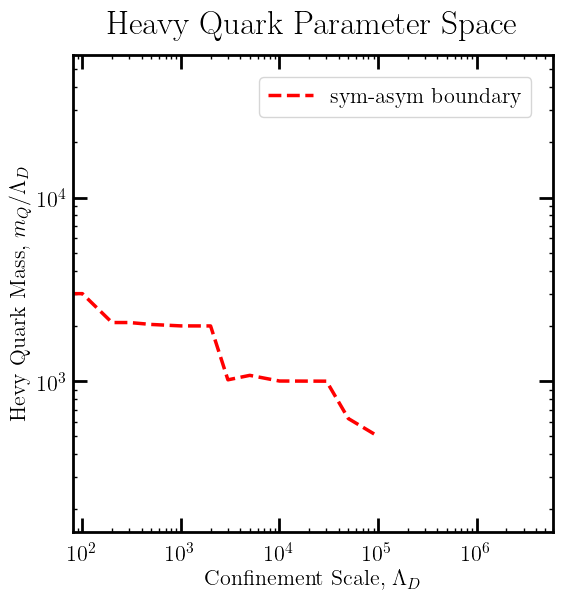

In [917]:
plt.figure()
plt.loglog()
plt.axis([80, 6e6, 150,6e4])
plt.plot(10**log10Lambdas[:-2]/1e9, asym[:-2], 
         color='red', linestyle='--', label='sym-asym boundary')
plt.legend()
plt.xlabel(r'Confinement Scale, $\Lambda_D$', fontsize=16)
plt.ylabel(r'Hevy Quark Mass, $m_Q/\Lambda_D$', fontsize=16)
plt.title('Heavy Quark Parameter Space')

## Scan for asymmetry line

In [585]:
%autoreload
pouya_check=False

# log10Lambdas = np.log10(
#     np.flipud([300000, 200000, 100000, 50000, 30000, 20000, 10000, 5000, 3000, 
#      2000, 1000, 500, 300, 200, 100, 50])) + 9

log10Lambdas = np.arange(11,16,.1)
data = np.zeros(log10Lambdas.size)


step=0.05
offset=1e3
log10guess = 3.3
for ii, LambdaD in enumerate(tqdm(10**log10Lambdas)):
    print("\nlog10LambdaD:", np.log10(LambdaD),'\n')
    
    bad_flag=False
    pre_init=None
    
    below=False
    above=False
    
    while ((not below) | (not above)) & (not bad_flag):#ii==0 | True:
        ratio = 10**log10guess
        print("log10 mq/LambdaD:", np.log10(ratio))

        try:
            mq = ratio*LambdaD
            R_1, Nq_init, Y_fo = get_compression_init(mq, LambdaD, Nc)
            yinit = np.log(R_1*LambdaD)
            pre_init = ct.get_init(
                collision_list, weights, mq, 
                LambdaD, Nc, 
                Nq_init, yinit+np.log(offset), yinit+np.log(offset-.001), 
                init=pre_init, 
                mxstep = 10000, rtol=1e-6, pion=False
            )
            if np.any(np.isnan(pre_init)):
                print('pre_init nan')
                raise ValueError('pre_init nan')


            Nq_init, suppress = get_suppression(
                ratio, LambdaD, 3, pre_init, offset=offset,
                rtol_init=1e-6, rtol=1e-8
            )
            val = suppress*np.sqrt(Nq_init)

            if  val < 1:
                print('below', val)
                below = True
                log10below = [log10guess, val]
                log10guess += step

            else:
                print('above', val)
                above = True
                log10above = [log10guess, val]
                log10guess -= step

            print('Initial Nq, Suppression: ', Nq_init, suppress)
        except ValueError:
            print('break!')
            bad_flag = True
         
    #interpolation
    if not bad_flag:
        data[ii] = (1-log10below[1])/(log10above[1]-log10below[1]) * (
            (log10above[0]-log10below[0])
        ) + log10below[0]
    
    else:
        data[ii] = 0
        
#     pickle.dump((log10Lambdas,data), open(outfolder+'asym_data.p','wb'))


log10LambdaD: 11.0 

log10 mq/LambdaD: 3.3
below 0.7929230548493451
Initial Nq, Suppression:  2.300893694092682e+19 1.6530377385723654e-10
log10 mq/LambdaD: 3.3499999999999996
above 2.3084197780697613
Initial Nq, Suppression:  2.7121988582666342e+19 4.4325538678944173e-10

log10LambdaD: 11.1 

log10 mq/LambdaD: 3.3
below 0.4819226100806572
Initial Nq, Suppression:  1.962849210375811e+19 1.087761875943469e-10
log10 mq/LambdaD: 3.3499999999999996
above 1.5731403404063593
Initial Nq, Suppression:  1.8593877420246196e+19 3.648232317156635e-10

log10LambdaD: 11.2 

log10 mq/LambdaD: 3.3
below 0.35471384939465805
Initial Nq, Suppression:  1.0895766163357542e+19 1.0746059929457905e-10
log10 mq/LambdaD: 3.3499999999999996
below 0.957475259609236
Initial Nq, Suppression:  1.0551270590285537e+19 2.947645017298638e-10
log10 mq/LambdaD: 3.3999999999999995
above 5.752472846242447
Initial Nq, Suppression:  1.0101473376883466e+19 1.8099318208368012e-09

log10LambdaD: 11.299999999999999 

log10 mq/La

KeyboardInterrupt: 

In [589]:
# (log10Lambdas,data2) = pickle.load(open(outfolder+'asym_data.p','rb'))

In [17]:
np.sqrt(LambdaD/mq)/np.sqrt(ct.mpl)

0.01

Text(0.5, 1.0, 'Asymmetry Line')

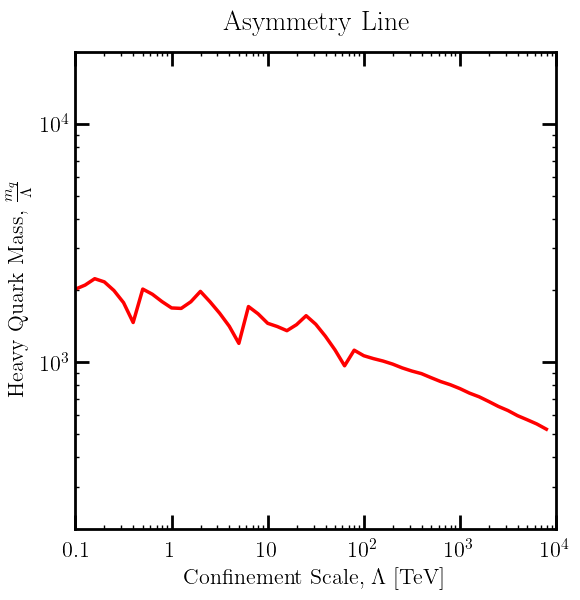

In [592]:
# goods = [log10Lambdas.copy(), data.copy()]

mask = (data != 0)

plt.figure()
plt.loglog()
plt.axis([.1,1e4,200,2e4])
# plt.plot(10**log10Lambdas[mask]/1e12, 10**data[mask], color='red')
plt.plot(10**log10Lambdas/1e12, 10**data2, color='red')
plt.xlabel(r'Confinement Scale, $\Lambda$ [TeV]', fontsize=16)
plt.ylabel(r'Heavy Quark Mass, $\frac{m_q}{\Lambda}$', fontsize=16)
plt.title(r'Asymmetry Line', fontsize=20)

# TODO

Generate Fig 1, right panel

# Scan for Relic Line

Define the observed relic density today through
$$
\rho_{DM,0} = \Omega_{DM,0} \rho_{crit,0} = m_{DM} n_{DM,esc} \left(\frac{T_{CMB,0}}{\Lambda_D}\right)^3
$$
[Fix the incorrect redshifting above]therefore,
$$
\begin{alignat}{1}
\frac{m_{DM} n_{DM,esc}}{\Lambda_D^3} &= \frac{\rho_{DM,0}}{T_{CMB,0}^3}\\ 
&= 10^{14} \, eV \, .
\end{alignat}
$$

To calculate $n_{DM,esc}$ we will use
$$
n_{DM,esc} = Y_{DM,fo} s(\Lambda_D) \times \mathcal{S}
$$
where $\mathcal{S}$ is the suppression factor.

In [ ]:
%autoreload
pouya_check=False

# log10Lambdas = np.log10(
#     np.flipud([300000, 200000, 100000, 50000, 30000, 20000, 10000, 5000, 3000, 
#      2000, 1000, 500, 300, 200, 100, 50])) + 9

#This time start at high Lambdas and step down
log10Lambdas = np.arange(14,16,.1)
data = np.zeros(log10Lambdas.size)


step=0.05
offset=1e3
log10guess = 3.4
for ii, LambdaD in enumerate(tqdm(10**log10Lambdas)):
    print("\nlog10LambdaD:", np.log10(LambdaD),'\n')
    
    bad_flag=False
    pre_init=None
    
    below=False
    above=False
    
    while ((not below) | (not above)) & (not bad_flag):#ii==0 | True:
        ratio = 10**log10guess
        print("log10 mq/LambdaD:", np.log10(ratio))

        try:
            mq = ratio*LambdaD
            R_1, Nq_init, Y_fo = get_compression_init(mq, LambdaD, Nc)
            yinit = np.log(R_1*LambdaD)
            pre_init = ct.get_init(
                collision_list, weights, mq, 
                LambdaD, Nc, 
                Nq_init, yinit+np.log(offset), yinit+np.log(offset-.001), 
                init=pre_init, 
                mxstep = 10000, rtol=1e-6, pion=False
            )
            if np.any(np.isnan(pre_init)):
                print('pre_init nan')
                raise ValueError('pre_init nan')


            Nq_init, suppress = get_suppression(
                ratio, LambdaD, 3, pre_init, offset=offset,
                rtol_init=1e-6, rtol=1e-8
            )
            
            sc = ct.s(T=LambdaD, LambdaD=LambdaD, Nc=Nc)
            n_fo = Y_fo*sc
            mDM = LambdaD*ct.mL(mq, LambdaD, 'B')
            rho_today = mDM * n_fo * suppress * (phys.TCMB(1)/LambdaD)**3
            relic_target = rho_today / phys.rho_DM

            if  relic_target < 1:
                print('below', relic_target)
                below = True
                log10below = [log10guess, relic_target]
                log10guess += step

            else:
                print('above', relic_target)
                above = True
                log10above = [log10guess, relic_target]
                log10guess -= step

            print('Initial Nq, Suppression: ', Nq_init, suppress)
        except ValueError:
            print('break!')
            bad_flag = True
         
    #interpolation
    if not bad_flag:
        data[ii] = (1-log10below[1])/(log10above[1]-log10below[1]) * (
            (log10above[0]-log10below[0])
        ) + log10below[0]
    
    else:
        data[ii] = 0

# Bubble Simulation

In [14]:
#Our assumption
Tc = LambdaD

#Latent Heat density
#    See Christ and Ding (1987), PRL
#    See Teper+ Table 7
DeltaL = 1.413 * Tc**4

#Surface tension
#   See Teper+ Table 15
mu_c = .02 * Tc**3

kappa = 16*np.pi/3 * (mu_c/Tc**3)**3 * (DeltaL/Tc**4)**(-2)
print('kappa:', kappa)

# Supercooling fraction
tau_p = 0.5 * np.sqrt(kappa/np.log(ct.Mpl/Tc))
print('1-Tc/Tp:', tau_p)

# Yang-Mills EoS
Ts_eos = Tc*np.array([0.660,0.904,0.980,1.061,1.100,1.150,1.200,1.278,1.400,1.500,1.600,1.700])
es_eos = np.array([0.0010,0.104,0.28,3.07,3.361,3.64,3.811,3.947,4.122,4.201,4.264,4.307])
YMeos_terp = interp1d(Ts_eos, es_eos,
                      bounds_error=False, 
                      fill_value=(es_eos[0], es_eos[-1]))

#Heat Capacity
deriv = np.diff(YMeos_terp(Ts_eos)*Ts_eos**4)/np.diff(Ts_eos)
Tmids = Ts_eos[:-1]+np.diff(Ts_eos)/2
CV_terp = interp1d(Tmids,
         deriv,
        bounds_error=False, fill_value=(deriv[0], deriv[-1]))

#Standard Model contribution to C_V
g_SM = 106.75
def C_V_SM(T):
    return 2*g_SM*np.pi**2/15 * T**3

cV = (CV_terp(Tc) + C_V_SM(Tc))/Tc**3

print('d(eps)/dt = ', cV)

kappa: 6.713581476681474e-05
1-Tc/Tp: 0.00068842739122469
d(eps)/dt =  174.25767516900328


In [17]:
x=0
Rbins = 10**np.arange(1,5,.5)
bub_list = np.zeros_like(Rbins.size+2)
# The extra two bins are over and underflow

while x<0.5:
    dt = ...
    Gamma = ...
    xdot = Gamma*(1-x)*4*np.pi/3 * Rc(T)^3
    xdot += sum([
        3*vw/R[i]*N[i] for i in np.arange(bub_list.size)
    ])
    
    Tdot = -H*T + xdot * DeltaL/cV/Tc**4

TypeError: unsupported operand type(s) for *: 'ellipsis' and 'int'

## Cross Checks

### initial condition

In [492]:
%autoreload

ratio = 10**(log10ratios[0]+2.0)
lam   = 10**log10Lambdas[0]
mq    = lam*ratio

R_1, Nq_init, Y_fo = get_compression_init(mq, lam, Nc)

yinit= np.log(R_1*lam)
y_vec = np.arange(yinit, 0, -.01)

yinit= np.log(R_1*lam)

if np.any(np.isnan(pre_init)):
    pre_init=None

pre_init = ct.get_init(
    collision_list, weights, mq, 
    lam, Nc, 
    Nq_init, yinit+np.log(1e3), yinit+np.log(10**(3-.001)),init=pre_init,
    mxstep = 10000, rtol=1e-6, pion=False
)
print(pre_init)

init = ct.get_init(
    collision_list, weights, mq, 
    lam, Nc, 
    Nq_init, yinit+np.log(1e3), yinit,init=pre_init+np.array([0,0,0]),
    mxstep = 10000, rtol=1e-6, pion=False
)
print(init)

[ 42.74610113 -15.53682287  -3.22487615]
[ 42.74610113 -15.53682285  16.76577947]


### collision terms

In [646]:
%autoreload
ratio = 1e3
lam   = 1e12
mq    = lam*ratio
R_1, Nq_init, Y_fo = get_compression_init(mq, lam, Nc)

yinit= np.log(R_1*lam)
# init = [np.log(Nq_init), -3.74315348, -32.70274368]

engLs = {part: ct.engL(mq, lam, part) for part in ct.inds}
mLs   = {part: ct.mL(mq, lam, part) for part in ct.inds}
logxsec_list = {process: np.log(ct.xsec(mq, lam, Nc, process)) 
                for process in ct.process_ind}


part = 'q'

llist = []

print(part+'\n')

tot=0
for coll, weight in zip(collision_list[part], weights[part]):
    term = weight*ct.collision(coll, init, yinit, mq, lam, 
                     Nc, part, np.exp(np.log(1e-3)), 
                               mLs, engLs, logxsec_list)
    llist.append(term)
    print(coll, term)
    tot+=term

llist = np.array(llist)
print('total:', tot)   
print('fine tuning:', tot/max(np.abs(llist)))

q

['q', 'bq', 'g', 'g'] 1.3944279464523572e-06
['q', 'bqq', 'bq', 'g'] 1.2107396477006789e-18
['q', 'bB', 'bqq', 'g'] 1.2846447851376505e-29
['q', 'bB', 'bq', 'bq'] 1.2846447851376505e-29
['q', 'q', 'qq', 'g'] 3.68207930611603e-07
['q', 'qq', 'B', 'g'] -2.2512321584627394e-20
['q', 'B', 'qq', 'qq'] 1.024936707646091e-29
['B', 'bqq', 'q', 'g'] -6.222382549118664e-43
['qq', 'bq', 'q', 'g'] -1.2107396477006789e-18
['B', 'bq', 'q', 'q'] -1.2846447851376505e-29
['B', 'bB', 'q', 'bq'] -6.602204948055843e-54
['qq', 'bqq', 'q', 'bq'] -5.864411191745542e-32
['qq', 'bB', 'q', 'bqq'] -6.222382549118664e-43
total: 1.7626358770639377e-06
fine tuning: 1.2640566201705574


In [630]:
%autoreload
ct.xsec(mq, LambdaD, Nc, 'asfpoij')*1e18

2.4341920760387015e-32


9.172047047474175e-12

In [ ]:
ct.collision(['q', 'B', 'qq', 'qq'], init, yinit, mq, lam, 
                     Nc, part, np.exp(log_vw(yinit, lam)), mLs, engLs, logxsec_list)

In [505]:
ct.collision(['q', 'q', 'qq', 'g'], init=[1,1,1], yinit, mq, lam, 
                     Nc, part, np.exp(log_vw(yinit, lam)), 
             mLs, engLs, logxsec_list)

array([7.38198774e+15])

In [ ]:
log_eq_fac = (
    mLs[coll[2]]+mLs[coll[3]]-mLs[coll[0]]-mLs[coll[1]] +
    3/2*np.log(mLs[coll[0]]) + 3/2*np.log(mLs[coll[1]])
    - 3/2*np.log(mLs[coll[2]]) - 3/2*np.log(mLs[coll[3]]) +
    np.log(gs[coll[0]]*gs[coll[1]]/gs[coll[2]]/gs[coll[3]])
)

In [609]:
ct.mL

<function compositools.mL(mq, LambdaD, hadron)>

In [606]:
collision_list

{'q': [['q', 'bq', 'g', 'g'],
  ['q', 'bqq', 'bq', 'g'],
  ['q', 'bB', 'bqq', 'g'],
  ['q', 'bB', 'bq', 'bq'],
  ['q', 'q', 'qq', 'g'],
  ['q', 'qq', 'B', 'g'],
  ['q', 'B', 'qq', 'qq'],
  ['B', 'bqq', 'q', 'g'],
  ['qq', 'bq', 'q', 'g'],
  ['B', 'bq', 'q', 'q'],
  ['B', 'bB', 'q', 'bq'],
  ['qq', 'bqq', 'q', 'bq'],
  ['qq', 'bB', 'q', 'bqq']],
 'qq': [['qq', 'bq', 'q', 'g'],
  ['qq', 'bqq', 'g', 'g'],
  ['qq', 'bqq', 'q', 'bq'],
  ['q', 'bB', 'bq', 'g'],
  ['qq', 'q', 'B', 'g'],
  ['q', 'B', 'qq', 'qq'],
  ['q', 'q', 'qq', 'g'],
  ['B', 'bq', 'qq', 'g'],
  ['B', 'bB', 'qq', 'bqq'],
  ['bB', 'qq', 'bqq', 'q'],
  ['B', 'bq', 'qq', 'bq']],
 'B': [['B', 'bq', 'qq', 'g'],
  ['B', 'bq', 'q', 'q'],
  ['B', 'bqq', 'q', 'g'],
  ['B', 'bqq', 'qq', 'bq'],
  ['B', 'bB', 'g', 'g'],
  ['B', 'bB', 'q', 'bq'],
  ['B', 'bB', 'qq', 'bqq'],
  ['q', 'qq', 'B', 'g'],
  ['q', 'B', 'qq', 'qq']]}

In [607]:
for i,part in enumerate(['q', 'qq', 'B']):
    print(part, init[i], sum([weight*ct.collision(coll, init+np.array([0,0,0]), yinit, 
                                         mq, lam, Nc, part, 
                                         np.exp(log_vw(yinit, lam)), mLs, engLs, 
                                         logxsec_list)
                       for coll, weight in zip(collision_list[part], weights[part])]))

NameError: name 'mLs' is not defined

### Example history

In [313]:
%autoreload

ratio = 10**(log10ratios[0]+2.0)
lam   = 10**log10Lambdas[0]
mq    = lam*ratio

R_1, Nq_init, Y_fo = get_compression_init(mq, lam, Nc)

yinit= np.log(R_1*lam)
y_vec = np.arange(yinit, 0, -.01)

pre_init = ct.get_init(
    collision_list, weights, mq, 
    lam, Nc, 
    Nq_init, yinit+np.log(1e3), yinit+np.log(1e3-.001), init=pre_init, 
    mxstep = 10000, rtol=1e-8, pion=False
)

init = ct.get_init(
    collision_list, weights, mq, 
    lam, Nc, 
    Nq_init, yinit+np.log(1e3), yinit, init=pre_init, 
    mxstep = 10000, rtol=1e-8, pion=False
)

init[2]+=5

out = ct.get_B(y_vec, init, collision_list, weights, mq, lam, 
         Nc, mxstep = 1000, rtol=1e-8, pion=False)

/Users/gregoryridgway/Desktop/DM/DH/DarkHistory/examples/Composite_DM/compositools.py:426: RuntimeWarning: invalid value encountered in add
  for coll, weight in zip(collision_list['q'], weights['q'])])
/Users/gregoryridgway/Desktop/DM/DH/DarkHistory/examples/Composite_DM/compositools.py:438: RuntimeWarning: invalid value encountered in add
  for coll, weight in zip(collision_list['B'], weights['B'])


In [443]:
%autoreload

ratio = 10**(log10ratios[0]+1.0)
lam   = 10**log10Lambdas[0]
mq    = lam*ratio

R_1, Nq_init, Y_fo = get_compression_init(mq, lam, Nc)

yinit= np.log(R_1*lam)
y_vec = np.arange(yinit, 0, -.01)

# pre_init = ct.get_init(
#     collision_list, weights, mq, 
#     lam, Nc, 
#     Nq_init, yinit+np.log(1e3), yinit+np.log(1e3-.001), init=None, 
#     mxstep = 10000, rtol=1e-8, pion=False
# )

# init = ct.get_init(
#     collision_list, weights, mq, 
#     lam, Nc, 
#     Nq_init, yinit+np.log(1e3), yinit, init=pre_init, 
#     mxstep = 10000, rtol=1e-8, pion=False
# )

y_vec = np.arange(yinit, yinit/2, -.01)
out = ct.get_B(y_vec, init, collision_list, weights, mq, lam, 
         Nc, mxstep = 1000, rtol=1e-3, pion=False)

/Users/gregoryridgway/Desktop/DM/DH/DarkHistory/examples/Composite_DM/compositools.py:382: RuntimeWarning: overflow encountered in exp
  return -np.exp(forward) + np.exp(backward)
/Users/gregoryridgway/Desktop/DM/DH/DarkHistory/examples/Composite_DM/compositools.py:382: RuntimeWarning: invalid value encountered in add
  return -np.exp(forward) + np.exp(backward)


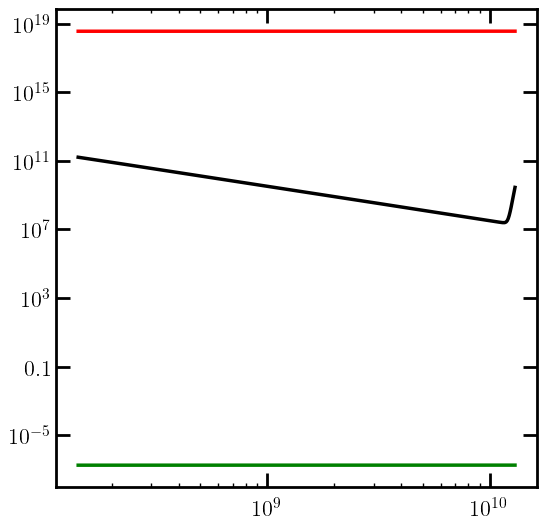

In [314]:
plt.figure()
plt.loglog()
plt.plot(np.exp(y_vec[0:]), np.exp(out[0:,0]), color='red')
plt.plot(np.exp(y_vec[0:]), np.exp(out[0:,1]), color='green')
plt.plot(np.exp(y_vec[0:]), np.exp(out[0:,2]), color='k')

In [196]:
np.log(Nq_init)

array([43.59662693])

In [261]:
%autoreload
ratio = 10**(log10ratios[0]+1.0)
lam   = 10**log10Lambdas[0]
mq    = lam*ratio

R_1, Nq_init, Y_fo = get_compression_init(mq, lam, Nc)

yinit= np.log(R_1*LambdaD)

relic_target = phys.omega_DM*phys.rho_crit/ct.mL(mq, lam, 'B')/phys.s0

Nq_init, suppr = get_suppression(ratio, lam, Nc=3, rtol_init=1e-6, rtol=1e-8)


print(np.sqrt(Nq_init)*suppr) # if >1, symmetric
print(Y_fo*max(suppr,1/np.sqrt(Nq_init))/relic_target) # if >1 overproduced

0.07924879833634561
2.0690870959139968e-19


In [ ]:
4734186.775448718
5.187423635132443e-13

# Old Results

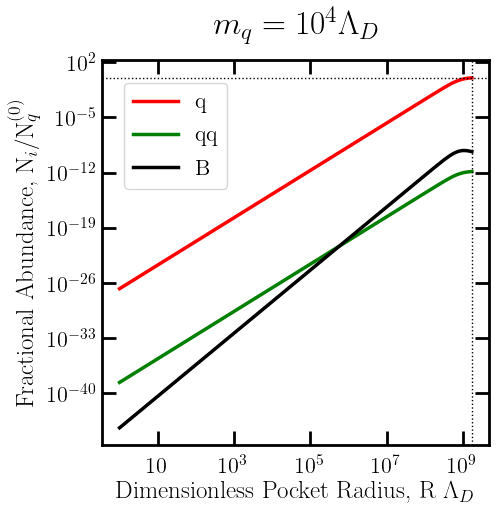

In [414]:
plt.figure(figsize=(5,5))
plt.loglog()
# plt.axis([1, np.exp(yinit), 1e-35, 1])
plt.plot(np.exp(y_vec), np.exp(soln[:,0])/Nq_init, color='red', label='q')
plt.plot(np.exp(y_vec), np.exp(soln[:,1])/Nq_init, color='green', label='qq')
plt.plot(np.exp(y_vec), np.exp(soln[:,2])/Nq_init, color='black', label='B')
# plt.plot(np.exp(y_vec), np.exp(soln[:,3])/Nq_init, linestyle = '--', color='black', label=r'$N_{esc}$')
plt.title('$m_q = 10^4 \Lambda_D$')
plt.xlabel('Dimensionless Pocket Radius, R $\Lambda_D$')
plt.ylabel('Fractional Abundance, N$_i$/N$^{(0)}_q$')
plt.axvline(RLinit, color='k', linestyle=':', linewidth=1.0)
plt.axhline(1.0, color='k', linestyle=':', linewidth=1.0)
plt.legend()

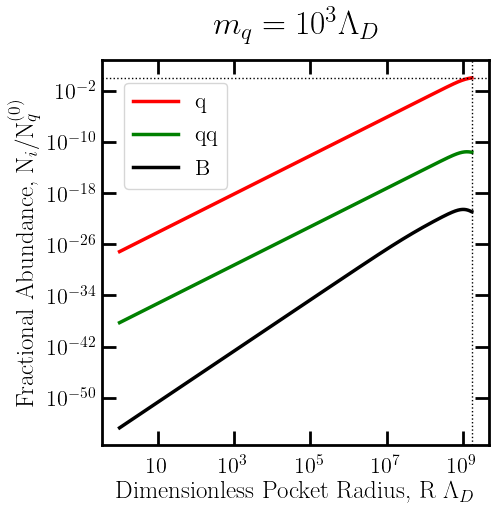

In [405]:
plt.figure(figsize=(5,5))
plt.loglog()
# plt.axis([1, np.exp(yinit), 1e-35, 1])
plt.plot(np.exp(y_vec), np.exp(soln[:,0])/Nq_init, color='red', label='q')
plt.plot(np.exp(y_vec), np.exp(soln[:,1])/Nq_init, color='green', label='qq')
plt.plot(np.exp(y_vec), np.exp(soln[:,2])/Nq_init, color='black', label='B')
# plt.plot(np.exp(y_vec), np.exp(soln[:,3])/Nq_init, linestyle = '--', color='black', label=r'$N_{esc}$')
plt.title('$m_q = 10^3 \Lambda_D$')
plt.xlabel('Dimensionless Pocket Radius, R $\Lambda_D$')
plt.ylabel('Fractional Abundance, N$_i$/N$^{(0)}_q$')
plt.axvline(RLinit, color='k', linestyle=':', linewidth=1.0)
plt.axhline(1.0, color='k', linestyle=':', linewidth=1.0)
plt.legend()

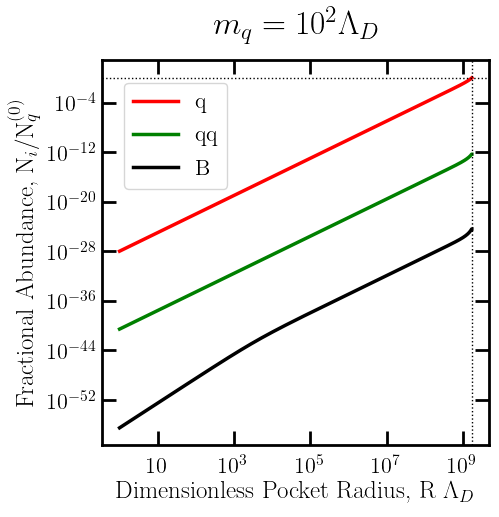

In [419]:
plt.figure(figsize=(5,5))
plt.loglog()
# plt.axis([1, np.exp(yinit), 1e-35, 1])
plt.plot(np.exp(y_vec), np.exp(soln[:,0])/Nq_init, color='red', label='q')
plt.plot(np.exp(y_vec), np.exp(soln[:,1])/Nq_init, color='green', label='qq')
plt.plot(np.exp(y_vec), np.exp(soln[:,2])/Nq_init, color='black', label='B')
# plt.plot(np.exp(y_vec), np.exp(soln[:,3])/Nq_init, linestyle = '--', color='black', label=r'$N_{esc}$')
plt.title('$m_q = 10^2 \Lambda_D$')
plt.xlabel('Dimensionless Pocket Radius, R $\Lambda_D$')
plt.ylabel('Fractional Abundance, N$_i$/N$^{(0)}_q$')
plt.axvline(RLinit, color='k', linestyle=':', linewidth=1.0)
plt.axhline(1.0, color='k', linestyle=':', linewidth=1.0)
plt.legend()

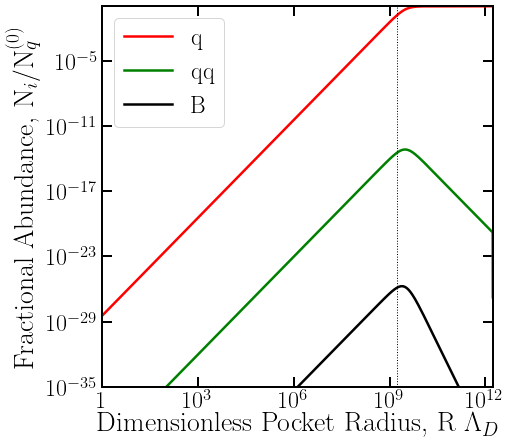

In [430]:
plt.figure(figsize=(7,7))
plt.loglog()
plt.axis([1, np.exp(yinit), 1e-35, 1])
plt.plot(np.exp(y_vec), np.exp(soln[:,0])/Nq_init, color='red', label='q')
plt.plot(np.exp(y_vec), np.exp(soln[:,1])/Nq_init, color='green', label='qq')
plt.plot(np.exp(y_vec), np.exp(soln[:,2])/Nq_init, color='black', label='B')
# plt.plot(np.exp(y_vec), np.exp(soln[:,3])/Nq_init, linestyle = '--', color='black', label=r'$N_{esc}$')
plt.xlabel('Dimensionless Pocket Radius, R $\Lambda_D$')
plt.ylabel('Fractional Abundance, N$_i$/N$^{(0)}_q$')
plt.axvline(RLinit, color='k', linestyle=':', linewidth=1.0)
plt.legend()

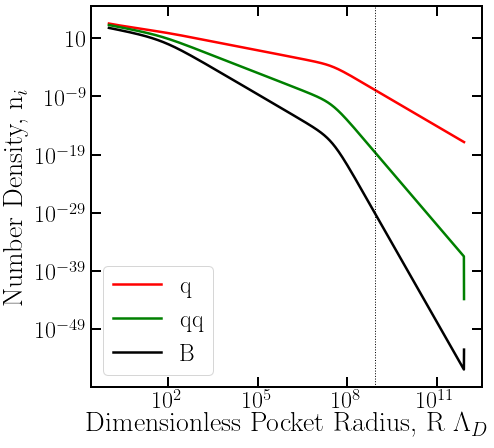

In [302]:
plt.figure(figsize=(7,7))
plt.loglog()
# plt.axis([1, np.exp(yinit), 1e-22, 1])
plt.plot(np.exp(y_vec), np.exp(soln[:,0])/np.exp(3*y_vec), color='red', label='q')
plt.plot(np.exp(y_vec), np.exp(soln[:,1])/np.exp(3*y_vec), color='green', label='qq')
plt.plot(np.exp(y_vec), np.exp(soln[:,2])/np.exp(3*y_vec), color='black', label='B')
# plt.plot(np.exp(y_vec), np.exp(soln[:,3])/Nq_init, linestyle = '--', color='black', label=r'$N_{esc}$')
plt.xlabel('Dimensionless Pocket Radius, R $\Lambda_D$')
plt.ylabel('Number Density, n$_i$')
plt.axvline(RLinit, color='k', linestyle=':', linewidth=1.0)
plt.legend()

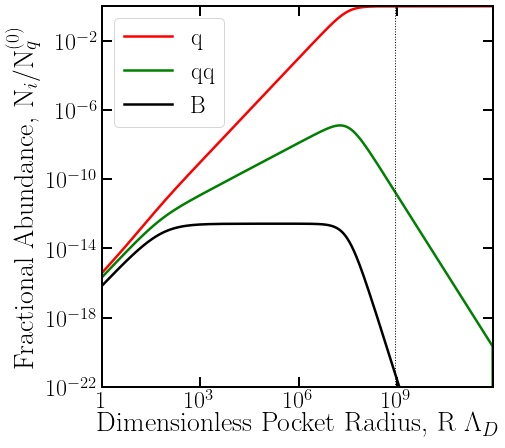

In [299]:
plt.figure(figsize=(7,7))
plt.loglog()
plt.axis([1, np.exp(yinit), 1e-22, 1])
plt.plot(np.exp(y_vec), np.exp(soln[:,0])/Nq_init, color='red', label='q')
plt.plot(np.exp(y_vec), np.exp(soln[:,1])/Nq_init, color='green', label='qq')
plt.plot(np.exp(y_vec), np.exp(soln[:,2])/Nq_init, color='black', label='B')
# plt.plot(np.exp(y_vec), np.exp(soln[:,3])/Nq_init, linestyle = '--', color='black', label=r'$N_{esc}$')
plt.xlabel('Dimensionless Pocket Radius, R $\Lambda_D$')
plt.ylabel('Fractional Abundance, N$_i$/N$^{(0)}_q$')
plt.axvline(RLinit, color='k', linestyle=':', linewidth=1.0)
plt.legend()

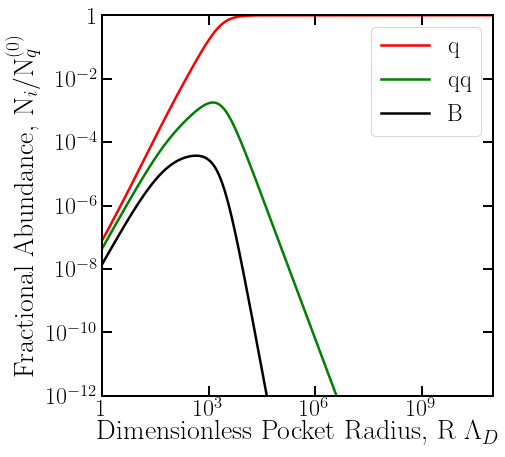

In [989]:
plt.figure(figsize=(7,7))
plt.loglog()
plt.axis([1, np.exp(yinit), 1e-12, 1])
plt.plot(np.exp(y_vec), np.exp(soln[:,0])/Nq_init, color='red', label='q')
plt.plot(np.exp(y_vec), np.exp(soln[:,1])/Nq_init, color='green', label='qq')
plt.plot(np.exp(y_vec), np.exp(soln[:,2])/Nq_init, color='black', label='B')
# plt.plot(np.exp(y_vec), np.exp(soln[:,3])/Nq_init, linestyle = '--', color='black', label=r'$N_{esc}$')
plt.xlabel('Dimensionless Pocket Radius, R $\Lambda_D$')
plt.ylabel('Fractional Abundance, N$_i$/N$^{(0)}_q$')
plt.legend()

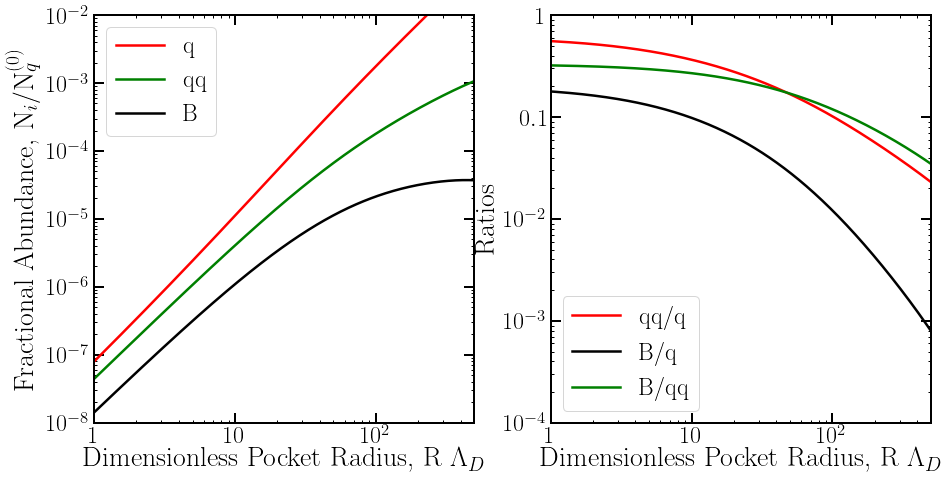

In [1022]:
fig, axarr = plt.subplots(1, 2, figsize=(15,7.5))

axarr[0].loglog()
# axarr[0].axis([1, np.exp(yinit), 1e-12, 1])
axarr[0].axis([1, 500, 1e-8, 1e-2])
axarr[0].plot(np.exp(y_vec), np.exp(soln[:,0])/Nq_init, color='red', label='q')
axarr[0].plot(np.exp(y_vec), np.exp(soln[:,1])/Nq_init, color='green', label='qq')
axarr[0].plot(np.exp(y_vec), np.exp(soln[:,2])/Nq_init, color='black', label='B')
# plt.plot(np.exp(y_vec), np.exp(soln[:,3])/Nq_init, linestyle = '--', color='black', label=r'$N_{esc}$')
axarr[0].set_xlabel('Dimensionless Pocket Radius, R $\Lambda_D$')
axarr[0].set_ylabel('Fractional Abundance, N$_i$/N$^{(0)}_q$')
axarr[0].legend()

axarr[1].loglog()
axarr[1].axis([1, 500, 1e-4, 1])
axarr[1].plot(np.exp(y_vec), np.exp(soln[:,1]-soln[:,0]), color='red', label='qq/q')
# plt.plot(np.exp(y_vec), np.exp(soln[:,1])/Nq_init, color='green', label='qq')
axarr[1].plot(np.exp(y_vec), np.exp(soln[:,2]-soln[:,0]), color='black', label='B/q')
axarr[1].plot(np.exp(y_vec), np.exp(soln[:,2]-soln[:,1]), color='green', label='B/qq')
# plt.plot(np.exp(y_vec), np.exp(soln[:,3])/Nq_init, linestyle = '--', color='black', label=r'$N_{esc}$')
axarr[1].set_xlabel('Dimensionless Pocket Radius, R $\Lambda_D$')
axarr[1].set_ylabel('Ratios')
axarr[1].legend()

# EDK Objections

In [93]:
0.65**4 * 9

1.6065562500000004

In [12]:
#Our assumption
Tc = LambdaD

#Latent Heat density
#    See Christ and Ding (1987), PRL
#    See Teper+ Table 7
DeltaL = 1.413 * Tc**4

#Surface tension
#   See Teper+ Table 15
mu_c = .02 * Tc**3

kappa = 16*np.pi/3 * (mu_c/Tc**3)**3 * (DeltaL/Tc**4)**(-2)
print('kappa:', kappa)

# Supercooling fraction
tau_p = 0.5 * np.sqrt(kappa/np.log(Mpl/Tc))
print('1-Tc/Tp:', tau_p)

# Yang-Mills EoS
Ts_eos = Tc*np.array([0.660,0.904,0.980,1.061,1.100,1.150,1.200,1.278,1.400,1.500,1.600,1.700])
es_eos = np.array([0.0010,0.104,0.28,3.07,3.361,3.64,3.811,3.947,4.122,4.201,4.264,4.307])
YMeos_terp = interp1d(Ts_eos, es_eos,
                      bounds_error=False, 
                      fill_value=(es_eos[0], es_eos[-1]))

#Heat Capacity
deriv = np.diff(YMeos_terp(Ts_eos)*Ts_eos**4)/np.diff(Ts_eos)
Tmids = Ts_eos[:-1]+np.diff(Ts_eos)/2
CV_terp = interp1d(Tmids,
         deriv,
        bounds_error=False, fill_value=(deriv[0], deriv[-1]))

#Standard Model contribution to C_V
g_SM = 106.75
def C_V_SM(T):
    return 2*g_SM*np.pi**2/15 * T**3

cV = (CV_terp(Tc) + C_V_SM(Tc))/Tc**3

print('d eps/dt = ', cV)

# tau_in = DeltaL/(CV_terp(Tc) + C_V_SM(Tc))/Tc
# print('Delta T/Tc input', tau_in)
# print('Fraction of plasma converted', tau_p/tau_in)

kappa: 6.713581476681474e-05


NameError: name 'Mpl' is not defined

In [337]:
(CV_terp(Tc) + C_V_SM(Tc))/Tc**3

174.25767516900328

In [375]:
np.log(2.)

0.6931471805599453

In [339]:
2*g_SM*np.pi**2/15

140.47736930883855

Text(0, 0.5, 'Dimensionless Heat Capacity, $C_V/T_c^3$')

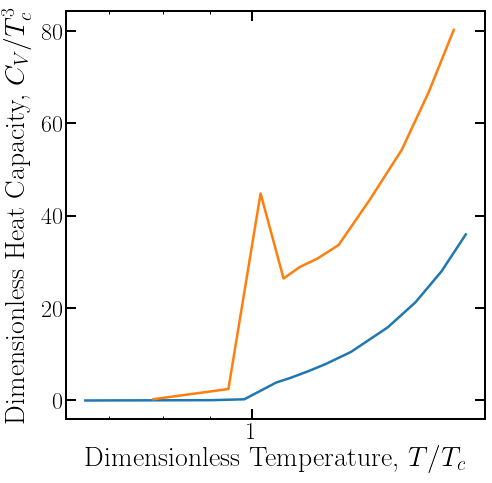

In [107]:
plt.figure(figsize=(7.5,7.5))
plt.xscale('log')
plt.plot(Ts_eos/Tc, YMeos_terp(Ts_eos)*Ts_eos**4/Tc**4, label='YM EoS')
plt.plot(Tmids/Tc, CV_terp(Tmids)/Tc**3, label=r'$C_V$')
# plt.title('Dimensionless Units')
plt.xlabel(r'Dimensionless Temperature, $T/T_c$')
plt.ylabel(r'Dimensionless Heat Capacity, $C_V/T_c^3$')

In [45]:
Ts_eos[:-1]+np.diff(Ts_eos)/2

array([0.782 , 0.942 , 1.0205, 1.0805, 1.125 , 1.175 , 1.239 , 1.339 ,
       1.45  , 1.55  , 1.65  ])

# Asymmetric Abundance Calculation

We will perform the asymmetric DM relic abundance calculation outlined in [[1]](#cite_ADM), with the help of [[2]](#cite_WIMP_Miracle). We start by defining the yield, $Y^{\pm} = \frac{n^\pm}{s}$, where the entropy $s = (2 \pi^2 / 45) g_*(T) T^3$, and the effective number of degrees of freedom has been WebplotDigitized from Fig. 2.

In [265]:
# parameters
Nc      = 3
Nf      = 1
LambdaD = 2e8 # Try TeV to compare with Pouya
mDM     = 500 * LambdaD    # 100 GeV
sigmav  = 5e-9*1e-18#1/mDM**2#5e-9*1e-18 # in eV^-2

T of confinement: 0.007400777727467321TeV


[10, 100, 1e-14, 0.002772486179584009]

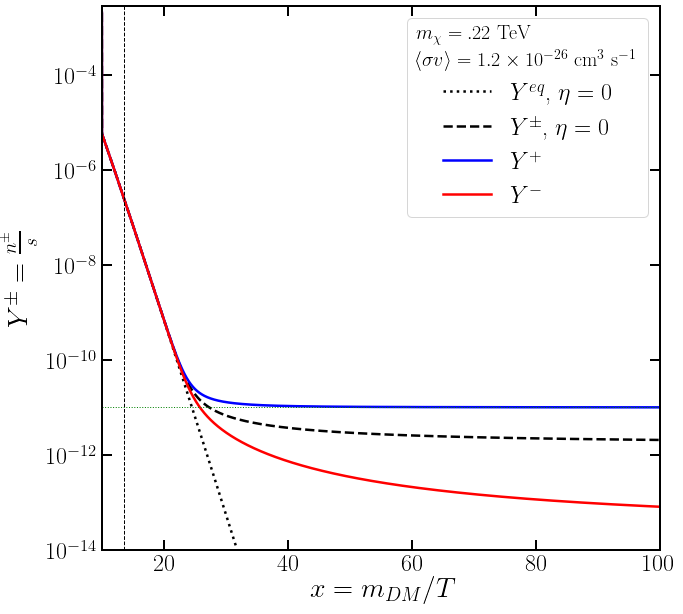

In [267]:
# initial conditions
xinit = 10       # initial x
Tinit = mDM / xinit # initial temperature

lnx_vec = np.arange(np.log(xinit), np.log(100), .001)
x_vec = np.exp(lnx_vec)
init_cond = np.array(np.log(Yeq(2, mDM, np.log(xinit), LambdaD)))

sym = get_history(init_cond, lnx_vec, mDM, sigmav, 0, pm = 'm', gDM=2)

eta = 1e-11
asym = get_history(init_cond, lnx_vec, mDM, sigmav, eta, pm = 'm', gDM=2)

plt.figure()
ax = plt.gca()
ax.set_yscale('log')
xtmp = 10**np.arange(np.log10(xinit), np.log10(40), .01)
plt.plot(xtmp, Yeq(2, mDM, xtmp, LambdaD), color='k', linestyle=':', label=r'$Y^{eq}$, $\eta = 0$')
plt.plot(x_vec, np.exp(sym),      color='k',    linestyle='dashed', label=r'$Y^\pm$, $\eta = 0$')
plt.plot(x_vec, np.exp(asym)+eta, color='blue', linestyle='solid',  label=r'$Y^+$')
plt.plot(x_vec, np.exp(asym),     color='red',  linestyle='solid',  label=r'$Y^-$')


plt.xlabel(r'$x = m_{DM}/T$')
plt.ylabel(r'$Y^\pm = \frac{n^{\pm}}{s}$')
leg = plt.legend()
leg.set_title('$m_\chi = .22$ TeV \n '
              +'$\langle \sigma v \\rangle = 1.2 \\times 10^{-26}$ cm$^3$ s$^{-1}$', prop = {'size': 20})
# plt.title(r'WIMP Miracle')#5 \times 10^{-8}$')

# plt.axhline(eta, color='k', linestyle='--')
(x_conf, Yp_conf, Ym_conf) = x_at_confinement(np.exp(asym)+eta, np.exp(asym), x_vec, mDM, LambdaD)
plt.axvline(x_conf, color='k', linewidth=1, linestyle='--')
print("T of confinement: "+str(mDM/x_conf/1e12)+"TeV")
plt.axhline(1/mDM, color='green', linewidth=1, linestyle=':', label='relic abundance')
# plt.axvline(19)
offset=.05
plt.axis([xinit, 100, np.exp(asym[-1]*(1+offset))*0 + 1e-14, np.exp(init_cond[0]*(1-offset))])

In [64]:
def get_mu(Yp, Ym, mDM, x):
    Y_eq = Yeq(2, mDM, x_conf, LambdaD)
    sinh = (Yp-Ym)/(2*Y_eq)
    return np.arcsinh(sinh)

mu = get_mu(Yp_conf, Ym_conf, mDM, x_conf)

Analytic Expression for late time abundance.

In [ ]:
def Ym_analytic(eta, mDM, xf):
    Tf = mDM/xf
    gstar = gstar_func(Tf)
    return eta/(
        np.exp(
            eta*(4*np.pi/np.sqrt(90)) * mDM*Mpl * np.sqrt(gstar) * sigmav/xf
        )-1
    )
    
def Yp_analytic(eta, mDM, xf):
    return Ym_analytic(eta, mDM, xf) + eta

x-axis: mDM
y_axis: eta
contour plots

# Hadrons

T of confinement: 10.0TeV


[10000000000000.0,
 1000000000000.0,
 8.110663369992057e-17,
 0.00016506120208160092]

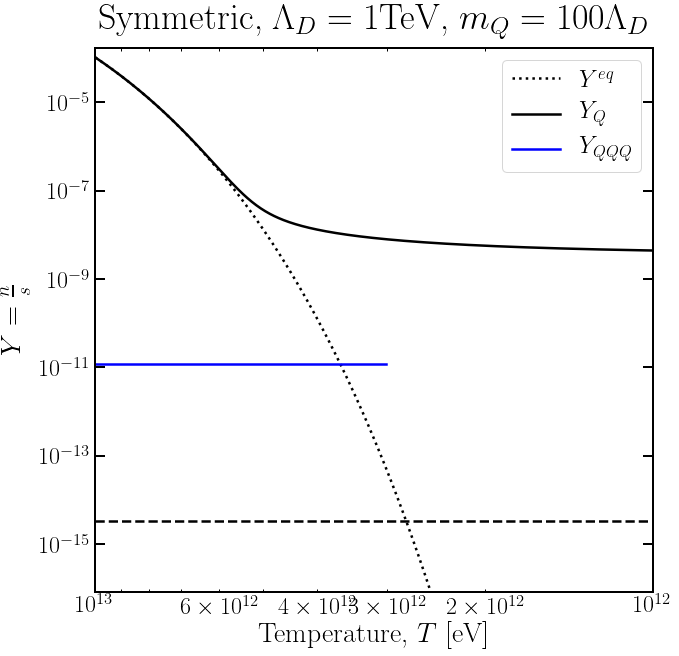

In [138]:
# parameters
Nc      = 3
LambdaD = 1e12 # Try TeV to compare with Pouya
mDM     = 100 * LambdaD    # 100 GeV
sigmav  = (.007/mDM)**2#1/mDM**2#5e-9*1e-18 # in eV^-2

# initial conditions
eta = 0
xinit = 10       # initial x
Tinit = mDM / xinit # initial temperature
lnYinit = np.log(Yeq(2, mDM, xinit, LambdaD))

x_vec = 10**np.arange(np.log10(xinit), 2, .001)
# x_vec = np.arange(xinit, 100, .01)
init_cond = np.array([np.log(Yeq(2, mDM, xinit, LambdaD))])

sym = get_history(init_cond, x_vec, mDM, sigmav, eta, pm = 'm', gDM=2)

(x_conf, Yp_conf, Ym_conf) = x_at_confinement(np.exp(asym)+eta, np.exp(asym), x_vec, mDM, LambdaD)


#---Baryon---#
xB_init = x_conf*mB/mDM
init_condB = np.log(Yeq(gDM=4, mB, xB_init, LambdaD))
mB = 3*mDM
sigmavB = sigmav * (mDM/mB)**2
xB_vec = 10**np.arange(np.log10(xB_init), np.log10(100), .001)

symB = get_history(init_condB, xB_vec, mB, sigmavB, eta, pm = 'm', gDM=2)

eta = 0
# asym = get_history(init_cond, x_vec, mDM, sigmav, eta, pm = 'm', gDM=2)

plt.figure()
ax = plt.gca()
# ax.set_yscale('log')
plt.loglog()
xtmp = 10**np.arange(np.log10(xinit), np.log10(40), .01)
plt.plot(mDM/xtmp,  Yeq(2, gstar_func(mDM/xtmp), xtmp, LambdaD), color='k', linestyle=':', label=r'$Y^{eq}$')
plt.plot(mDM/x_vec, np.exp(sym),      color='k',    linestyle='solid', label=r'$Y_Q$')
plt.plot(mB/xB_vec, np.exp(symB),      color='blue',    linestyle='solid', label=r'$Y_{QQQ}$')
# plt.plot(x_vec, np.exp(asym)+eta, color='blue', linestyle='solid',  label=r'$Y^+$')
# plt.plot(x_vec, np.exp(asym),     color='red',  linestyle='solid',  label=r'$Y^-$')

plt.axhline(1/mB, color='k', linestyle='--')


plt.xlabel(r'Temperature, $T$ [eV]')
plt.ylabel(r'$Y = \frac{n}{s}$')
leg = plt.legend()
plt.title(r'Symmetric, $\Lambda_D = 1$TeV,  $m_Q = 100 \Lambda_D$')#5 \times 10^{-8}$')

# plt.axhline(eta, color='k', linestyle='--')

plt.axvline(mDM/x_conf, color='k', linewidth=1, linestyle='--')
print("T of confinement: "+str(mDM/x_conf/1e12)+"TeV")
plt.axhline(5, color='green', linewidth=1, linestyle=':', label='relic abundance')
offset=.05
plt.axis([mDM/xinit, mDM/100, np.exp(asym[-1]*(1+offset))*1e-8, np.exp(init_cond[0]*(1-offset))])

# Cross-Checks with Pouya

In [ ]:
get_cross_check(1e13, 2, 1e12, 0)

In [ ]:
x_at_confinement(
    np.exp(sol)+eta, np.exp(sol), x_vec, m_Q, LambdaD, RC
)

In [239]:
def get_cross_check(m_Q, RC, LambdaD, eta):
    #Step 1: what is T_quarks(z_conf)?
    
    xinit = 10
    space = eq_spacing(gDM=2, mDM=m_Q, x=xinit)*LambdaD
    if space > RC:
        while space > RC:
            xinit/=1.005
            space = eq_spacing(gDM=2, mDM=m_Q, x=xinit)*LambdaD
        
        x_conf = space
            
    else:
        sigmav_q = 4*np.pi/m_Q**2
        Tinit = m_Q / xinit # initial temperature
        lnYinit = np.log(Yeq(gDM=2, gstar=gstar_func(Tinit), x=xinit))
        init_cond = np.array([lnYinit])
        lnx_vec = np.arange(np.log(xinit), np.log(100), .001)
        x_vec = np.exp(lnx_vec)
        sol = get_history(init_cond, x_vec, m_Q, sigmav_q, eta, pm = 'm', gDM=2)

        (x_conf, Yp_conf, Ym_conf) = x_at_confinement(
            np.exp(sol)+eta, np.exp(sol), x_vec, m_Q, LambdaD, RC
        )
    TQ_conf = m_Q/x_conf
    print('TQ_conf [GeV]:', TQ_conf/1e9)
    print('xQ_conf:', x_conf)
    
    s_tot = entropy_func(TQ_conf, LambdaD)
 
    # s(z_conf)
    # T_hadrons(z_conf)
get_cross_check(1e13, 2, 1e12, 0)
mGB = 3*m_Q
# Y_B(z_conf)
# Y_GB(z_conf)

sigmav_had = 1e-2 * 4*np.pi/LambdaD**2
Gamma_GB = 0
# GB in equilibrium?
# If not, solve Boltz eqns for Y_B(\infty)

sigmav_had = 1e-5 * 4*np.pi/LambdaD**2
# GB in equilibrium?
# If not, solve Boltz eqns for Y_B(\infty)

TQ_conf [GeV]: [5032.47926583]
xQ_conf: [1.98709214]


In [ ]:
m_Q = 1e5
#repeat

In [77]:
def get_hadron_history(init_cond, x_vec, mDM, sigmav, eta, pm = 'm', gDM=2):
    """Returns the ionization and thermal history of the IGM. 

    Parameters
    ----------
    init_cond : array
        Array containing [initial temperature, initial xe]
    pm        : string
        plus or minus, 'p' or 'm'

    Returns
    -------
    list of ndarray
        [lnY+ or lnY-]. 

    Note
    ----
    Following 1104.5548, eqn. 11 or 12

    """
    if pm == 'm':
        sign = 1
    elif pm == 'p':
        sign = -1
    else:
        raise ValueError("pm must be 'p' or 'm'")
    
    def lam(gstar):
        return 4*np.pi*mDM*Mpl*np.sqrt(gstar/90)
    
    def lnY_diff_eq(var, x):
        # Returns an array of values for [dY+/dx, dY-/dx].
        # var is the [Y+, Y-] inputs. 

        def dlnY_dx(lnY, x):
            T = mDM/x
            gstar = gstar_func(T)
            return (
               -(lam(gstar)*sigmav/x**2) * (np.exp(lnY) + sign * eta - Yeq(gDM, gstar, x)**2 * np.exp(-lnY))
            )

        
        lnY = var[0]

        return [
            dlnY_dx(lnY, x)
        ]
    
    soln = odeint(lnY_diff_eq, init_cond, x_vec, mxstep = 1000)

    return soln[:,0]

# Smarter Code

In [ ]:
def get_history(init_cond, x_vec, mDM, sigmav, eta, pm = 'm', gDM=2):
    """Returns the ionization and thermal history of the IGM. 

    Parameters
    ----------
    init_cond : array
        Array containing [initial temperature, initial xe]
    pm        : string
        plus or minus, 'p' or 'm'

    Returns
    -------
    list of ndarray
        [lnY+ or lnY-]. 

    Note
    ----
    Following 1104.5548, eqn. 11 or 12

    """
    if pm == 'm':
        sign = 1
    elif pm == 'p':
        sign = -1
    else:
        raise ValueError("pm must be 'p' or 'm'")
    
    def lam(gstar):
        return 4*np.pi*mDM*Mpl*np.sqrt(gstar/90)
    
    
    
    def lnY_diff_eq(var, x):
        # Returns an array of values for [dY+/dx, dY-/dx].
        # var is the [Y+, Y-] inputs. 

        def dlnY_dx(lnY, x):
            T = mDM/x
            gstar = gstar_func(T)
            return (
               -(lam(gstar)*sigmav/x**2) * (np.exp(lnY) + sign * eta - Yeq(gDM, gstar, x)**2 * np.exp(-lnY))
            )

        
        lnY = var[0]

        return [
            dlnY_dx(lnY, x)
        ]
    
    soln = odeint(lnY_diff_eq, init_cond, x_vec, mxstep = 1000)

    return soln[:,0]

# Bibliography

[1]<a id='cite_ADM'></a>          https://arxiv.org/pdf/1104.5548v2.pdf

[2]<a id='cite_WIMP_Miracle'></a> https://arxiv.org/pdf/1204.3622.pdf

[3]<a id='cite_PDG_QCD'></a>      http://pdg.lbl.gov/2009/reviews/rpp2009-rev-qcd.pdf

# Old Work

## Scan over $m_q$ and $\Lambda_D$

In [791]:
# parameters
Nc  = 3
xinit = 10

inc = 0.25
# log10Lambdas = np.arange(10,15+inc/2,inc)

#ratios = m/LambdaD
# log10ratios = np.arange(2, 5.25+inc/2, inc)

log10Lambdas = np.log10(
    np.flipud([300000, 200000, 100000, 50000, 30000, 20000, 10000, 5000, 3000, 
     2000, 1000, 500, 300, 200, 100, 50])) + 9

log10ratios = np.log10(np.flipud([100000, 50000, 30000, 20000, 10000, 
                   5000, 3000, 2000, 1000, 500, 300, 200]))

relics = np.zeros((log10Lambdas.size, log10ratios.size))

for j, lam in enumerate(tqdm(10**log10Lambdas)):
    print('Lambda: ', lam/1e12, 'TeV')
    for k, log10ratio in enumerate(log10ratios):
        mDM     = 10**log10ratio * lam
#         alph    = ct.alpha_rBohr(mDM, lam)
#         alph    = ct.alpha_s(mDM, LambdaD, Nc)
#         sigmav  = np.pi*(alph/mDM)**2
        sigmav = ct.xsec(mDM, lam, Nc, 'qbq_gg')
        Tinit   = mDM / xinit
        xfinal  = mDM/lam

        lnx_vec      = np.arange(np.log(xinit), np.log(xfinal), .001)
        x_vec        = np.exp(lnx_vec)
        init_cond    = np.array(np.log(ct.Yeq(2, mDM, xinit, lam, Nc)*1.001))
        sym          = ct.get_history(init_cond, lnx_vec, mDM, sigmav, lam, Nc, gDM=2)
        relics[j][k] = sym[-1]

Lambda:  0.049999999999999996 TeV
Lambda:  0.1 TeV
Lambda:  0.20000000000000004 TeV
Lambda:  0.3000000000000001 TeV
Lambda:  0.49999999999999994 TeV
Lambda:  1.0 TeV
Lambda:  2.0000000000000004 TeV
Lambda:  3.000000000000001 TeV
Lambda:  4.999999999999999 TeV
Lambda:  10.0 TeV
Lambda:  20.000000000000004 TeV
Lambda:  30.00000000000001 TeV
Lambda:  49.99999999999999 TeV
Lambda:  100.0 TeV
Lambda:  200.00000000000003 TeV
Lambda:  300.0000000000001 TeV


In [792]:
log10nfo_tmp = RegularGridInterpolator(points=(
    (log10Lambdas, log10ratios)), values=np.log10(relics), method='linear')
def Yfo_func(LambdaD, ratio):
    # extrapolation: LambdaD
    log10LambdaD = np.log10(LambdaD)
    if isinstance(LambdaD*1.0, float):
        log10LambdaD = np.array([log10LambdaD])
    log10LambdaD[log10LambdaD>log10Lambdas[-1]] = log10Lambdas[-1]
    log10LambdaD[log10LambdaD<log10Lambdas[0]] = log10Lambdas[0]
    
    # extrapolation: mDM/LambdaD
    log10ratio = np.log10(ratio)
    if isinstance(ratio*1.0, float):
        log10ratio = np.array([log10ratio])
    log10ratio[log10ratio>log10ratios[-1]] = log10ratios[-1]
    log10ratio[log10ratio<log10ratios[0]] = log10ratios[0]
    
    return 10**log10nfo_tmp((log10LambdaD, log10ratio))

In [793]:
Yfo_func(10**log10Lambdas, 10**log10ratios[5])/relics[:,5]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

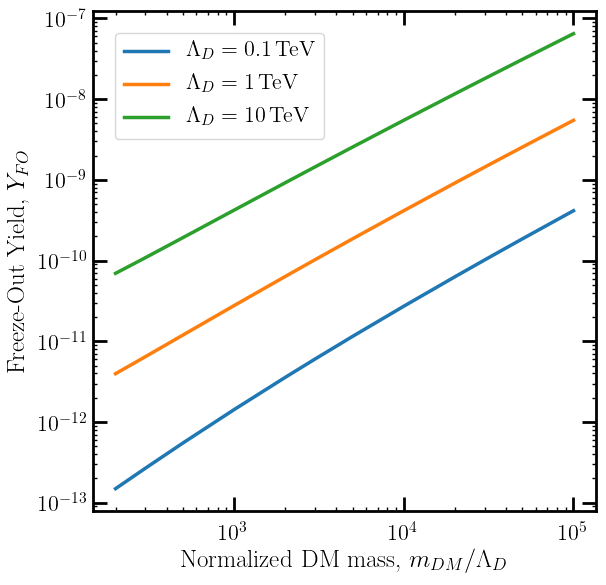

In [794]:
plt.figure(figsize=(6.5,6.5))
ratios = 10**log10ratios
ax = plt.gca()
ax.loglog()
plt.plot(ratios, Yfo_func(1e11, ratios), label=r'$\Lambda_D = 0.1\,$TeV')
plt.plot(ratios, Yfo_func(1e12, ratios), label=r'$\Lambda_D = 1\,$TeV')
plt.plot(ratios, Yfo_func(1e13, ratios), label=r'$\Lambda_D = 10\,$TeV')
# plt.plot(10**log10mDM_list, 10**relics2[0], color='k', linestyle=':', label=r'$\Lambda_D = 1\,$TeV')

plt.xlabel(r'Normalized DM mass, $m_{DM}/\Lambda_D$')
plt.ylabel(r'Freeze-Out Yield, $Y_{FO}$')
leg = plt.legend()
# plt.savefig('/Users/gregoryridgway/Desktop/Composite DM/FO_yield.pdf')

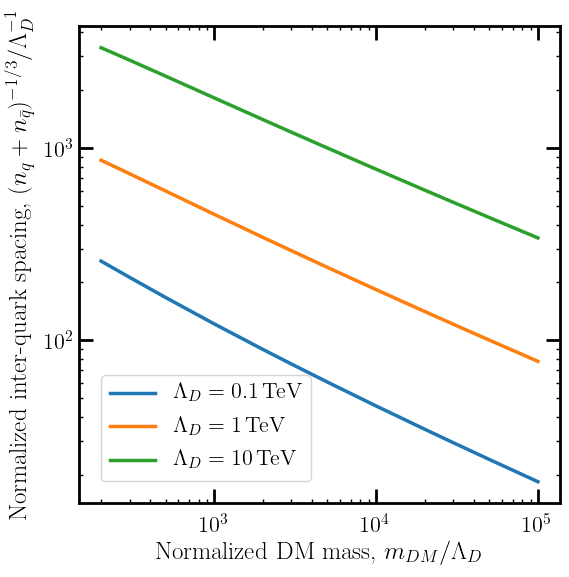

In [795]:
plt.figure()
ax = plt.gca()
ax.loglog()

s_c = ct.s(LambdaD, LambdaD, Nc)
labels=['0.1', '1', '10']
for i, lam in enumerate([1e11,1e12,1e13]):
    plt.plot(ratios, (2*Yfo_func(lam, ratios)*s_c*(4*np.pi/3))**(-1/3)*lam, 
             label=r'$\Lambda_D = '+labels[i]+'\,$TeV')

plt.xlabel(r'Normalized DM mass, $m_{DM}/\Lambda_D$')
plt.ylabel(r'Normalized inter-quark spacing, $(n_q+n_{\bar{q}})^{-1/3}/\Lambda_D^{-1}$')
leg = plt.legend()
# plt.savefig('/Users/gregoryridgway/Desktop/Composite DM/FO_spacing.pdf')

# Scratchwork

In [127]:
def get_history_pm(init_cond, x_vec, mDM, sigmav, gDM=2):
    """Returns the ionization and thermal history of the IGM. 

    Parameters
    ----------
    init_cond : array
        Array containing [initial temperature, initial xe]

    Returns
    -------
    list of ndarray
        [Y+, Y-]. 

    Note
    ----
    Following 1104.5548

    """
    
    def lam(gstar):
        return 4*np.pi*mDM*Mpl*np.sqrt(gstar/90)
    
    def Yeq2(gstar, x):
        return 0.145*(gDM/gstar)**2 * x**3 * np.exp(-2*x)
    
    def Ypm_diff_eq(var, x):
        # Returns an array of values for [dY+/dx, dY-/dx].
        # var is the [Y+, Y-] inputs. 

        def dYp_dz(Yp, Ym, x):
            T = mDM/x
            gstar = gstar_func(T)
            return (
               -(lam(gstar)*sigmav/x**2) * (Yp*Ym - Yeq2(gstar, x))
            )
        
        def dYm_dz(Yp, Ym, x):
            return dYp_dz(Yp, Ym, x)

        
        Yp, Ym = var[0], var[1]

        return [
            dYp_dz(Yp, Ym, x), 
            dYm_dz(Yp, Ym, x)
        ]
    
    soln = odeint(Ypm_diff_eq, init_cond, x_vec, mxstep = 1000)

    return soln

In [374]:
Mpl

2.4e+27

In [614]:
%autoreload

init = np.log([1e8, 1e-12, 1e-12])
yinit = 25.0

v_tmp = np.exp(yinit)/LambdaD*ct.hubble(LambdaD,True,LambdaD,Nc)
3/(4*np.pi)*ct.collision(
    ['q','q','g','g'], 
    init, yinit, 
    mq, LambdaD,Nc,
    'q',
    v_w = v_tmp
)*np.exp(init[0])

In [289]:
%autoreload
for num,part in enumerate(['q', 'qq', 'B']):
    llist = [3/8/np.pi*weight*ct.collision(coll, init, yinit, mq, LambdaD, Nc, part, v_tmp) 
        for coll, weight in zip(collision_list[part], weights[part])] 
    print(part,  sum(llist), '\n')

q [8.99105899e-10] 

qq [-2.573838e+16] 

B [7.92641099e+11] 



$$N_{Pouya} = n \times R^3, \,\,
N_{Greg} = \frac{4 \pi }{3}n \times R^3
$$

In [102]:
A=1
kappa = 1e-3
M_star = Mpl/np.sqrt(ct.get_gstar(LambdaD,True,LambdaD, Nc)[0])
prnth_fac = v_w**3 * A * kappa**2 * (M_star/LambdaD)**4
L = np.log(prnth_fac)
L += -6*np.log(6)
L += -6*np.log((1/6)*np.log(prnth_fac) - np.log(6))

tau_p = np.sqrt(kappa/L)

nL_bubble_p = A * LambdaD**2 * M_star * np.exp(
    -kappa/tau_p**2) * tau_p**3/(2*kappa)/LambdaD**3

RLinit = nL_bubble_p**(-1/3)
print(RLinit/1e9)

NameError: name 'v_w' is not defined

# Embedded Runge-Kutta

Let's solve $\dot{x} = t$, $\dot{y} = t^2$

In [423]:
init = np.array([1,2])

def deriv(t, y):
    return np.array([t, np.sin(t)])

def sol(t, init):
    return np.array([init[0]+t**2/2, init[1]+1-np.cos(t)])

In [424]:
def rk(deriv, init, t0, t_end, step, rtol=0.001, atol=1e-6):
    
    # Constants -- Cash-Karp
    ca  = np.array([0, 1./5, 3./10, 3./5, 1, 7./8])
    cb  = np.array([
        [0, 0, 0, 0, 0], 
        [1./5, 0, 0, 0, 0], 
        [3./40, 9./40, 0, 0, 0],
        [3./10, -9./10, 6./5, 0, 0], 
        [-11./54, 5./2, -70./27, 35./27, 0], 
        [1631./55296, 175./512, 575./13824, 44275./110592, 253./4096]
    ])
    cc  = np.array([37./378, 0, 250./621, 125./594, 0, 512./1771])
    ccs = np.array([2825./27648, 0, 18575./48384, 13525./55296, 277./14336, 1./4])
    
    k   = np.zeros((6,init.size))
    yp,yn,ys  = np.zeros(6),np.zeros(6),np.zeros(6)
    
    # Initialize the loop
    y     = init 
    t_cur = t0
    
    ylist = [init]
    tlist = [t_cur]
    while t_cur < t_end:
        # Let the last step take you just to t_end
        if t_cur+step > t_end:
            step=t_end-t_cur
        for i in np.arange(6):
            yp = y+np.dot(cb[i],k[:5])
            k[i] = step*deriv(t_cur+ca[i]*step, yp);  
            
        ys = y + np.dot(ccs,k)
        yn = y + np.dot(cc,k)
        
        #constraints on relative and absolute error
        delta = np.sum(np.sqrt(np.abs(ys-yn)))
        norm = np.sum(np.sqrt(np.abs(yn)))
        if norm>0:
            Delta = np.sum(np.sqrt(np.abs(ys-yn)))/norm
        else:
            Delta = 0
            
        if(Delta>delta): 
            delta=Delta
            
        if delta == 0:
            delta = rtol
        
        if(delta > rtol):
            step = 0.9*step*(rtol/delta)**0.2
        else:
            y = yn
            t_cur += step;
            
            tlist.append(t_cur)
            ylist.append(y)
        
            # adjust next step
            dtau = 0.9*step*(rtol/delta)**0.2
            if(step>0.05): 
                step=0.05
                
    return np.array(tlist), np.array(ylist)

In [425]:
ts, ys = rk(deriv, init, 0, 4, .01, rtol=0.1, atol=1e-6)

In [426]:
len(ts)

402

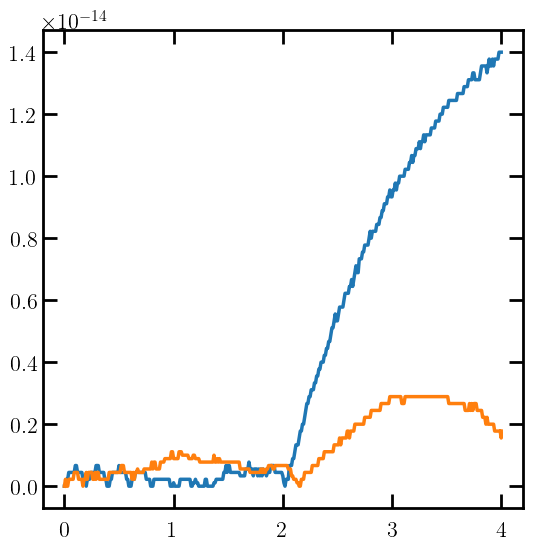

In [428]:
plt.figure()
plt.plot(ts, np.abs(1-ys[:,0]/sol(ts,init)[0]), color='C0')
# plt.plot(ts, ys[:,0], color='C0')
# plt.plot(ts, sol(ts,init)[0], linestyle = '--', color='C0')

plt.plot(ts, np.abs(1-ys[:,1]/sol(ts,init)[1]), color='C1')
# plt.plot(ts, ys[:,1], color='C1')
# plt.plot(ts, sol(ts,init)[1], linestyle = '--', color='C1')